# Noise-Based Machine Unlearning: A Comparative Study

**Author:** Eshaan  
**Institution:** Undergraduate Thesis  
**Date:** 2025

---

## Abstract

This notebook presents a comprehensive experimental study of noise-based machine unlearning strategies applied to neural network classifiers. Machine unlearning addresses the challenge of removing the influence of specific training data from a trained model without complete retraining—a capability increasingly mandated by regulations like GDPR's "right to be forgotten." We implement and evaluate five noise-based unlearning approaches: Gaussian noise injection, Laplacian noise injection, adaptive (magnitude-proportional) noise, layer-wise progressive noise, and gradient-based unlearning with noise. Our experiments use TabNet classifiers on synthetic spiral datasets, providing clear visualization of decision boundary changes. We evaluate each strategy across three dimensions: forgetting effectiveness (forget set accuracy should approach random guessing), utility preservation (retain set performance), and membership inference attack resistance.

---

## Table of Contents

1. [Introduction & Theoretical Background](#1-introduction)
2. [Environment Setup & Reproducibility](#2-setup)
3. [Dataset Generation & Exploration](#3-dataset)
4. [Baseline Model Training](#4-baseline)
5. [Unlearning Strategy Implementations](#5-strategies)
6. [Experimental Design: Forget Requests](#6-experiments)
7. [Comprehensive Evaluation](#7-evaluation)
8. [Hyperparameter Optimization](#8-optimization)
9. [Results Analysis & Visualization](#9-results)
10. [Conclusions & Future Work](#10-conclusions)
11. [References](#11-references)

---

<a id="1-introduction"></a>
## 1. Introduction & Theoretical Background

### 1.1 What is Machine Unlearning?

Machine unlearning refers to the process of removing the influence of specific training data points from a trained machine learning model. The naive approach—retraining the model from scratch on the remaining data—is computationally prohibitive for large models and datasets. Machine unlearning algorithms aim to achieve equivalent results with significantly less computation.

### 1.2 Why Noise-Based Approaches?

Noise-based unlearning offers several advantages:

- **No retraining required:** The original model's parameters are perturbed rather than recomputed
- **Theoretical guarantees:** Connections to differential privacy provide (ε,δ)-certified removal guarantees
- **Computational efficiency:** O(p) complexity where p is the number of parameters, versus O(n·p·e) for full retraining
- **Flexibility:** Can be applied post-hoc to any trained model

### 1.3 Theoretical Foundation

The theoretical basis for noise-based unlearning comes from Guo et al. (2020), who established **(ε,δ)-certified removal**. The key insight is that adding calibrated Gaussian noise to model parameters can mask the residual influence of removed data points, making the unlearned model statistically indistinguishable from a model retrained without that data.

For certified (ε,δ)-unlearning, the noise scale σ is computed as:

$$\sigma = \frac{\sqrt{2 \ln(1.25/\delta)} \cdot \text{sensitivity}}{\epsilon}$$

### 1.4 Evaluation Criteria

We evaluate unlearning quality across three dimensions:

1. **Forgetting Effectiveness:** Accuracy on forget set should approach random guessing (1/C for C classes = 25% for our 4-class problem)
2. **Utility Preservation:** Accuracy on retain set should remain high (target: >90%)
3. **Privacy Guarantee:** Membership Inference Attack success rate should approach 50% (random guessing)

---

<a id="2-setup"></a>
## 2. Environment Setup & Reproducibility

### 2.1 Import Libraries

We organize imports by category for clarity and maintainability.

In [34]:
# =============================================================================
# STANDARD LIBRARY IMPORTS
# =============================================================================
import copy
import time
import warnings
from typing import Dict, List, Tuple, Optional, Callable
from dataclasses import dataclass

# =============================================================================
# NUMERICAL & DATA PROCESSING
# =============================================================================
import numpy as np
from numpy import pi
import pandas as pd

# =============================================================================
# MACHINE LEARNING FRAMEWORKS
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# =============================================================================
# TABNET - SPECIALIZED TABULAR DATA ARCHITECTURE
# =============================================================================
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric

# =============================================================================
# SCIKIT-LEARN - PREPROCESSING & EVALUATION
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    roc_auc_score,
    f1_score
)

# =============================================================================
# VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns

# =============================================================================
# PROGRESS TRACKING
# =============================================================================
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"  PyTorch version: {torch.__version__}")
print(f"  NumPy version: {np.__version__}")
print(f"  Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

✓ All libraries imported successfully
  PyTorch version: 2.7.1+cpu
  NumPy version: 2.3.1
  Device: CPU


### 2.2 Reproducibility Configuration

Setting random seeds ensures that experiments are reproducible across different runs. This is crucial for scientific validity and debugging.

In [ ]:
# =============================================================================
# REPRODUCIBILITY CONFIGURATION
# =============================================================================
# Following Bronze/Silver/Gold reproducibility standards (Nature Methods, 2022)
# All random states are explicitly set and documented

@dataclass
class ExperimentConfig:
    """Central configuration for all experiment parameters.
    
    Centralizing configuration improves reproducibility and makes
    it easy to modify experimental parameters in one place.
    """
    # Random seed for reproducibility
    seed: int = 42
    
    # Dataset parameters
    samples_per_class: int = 300
    num_classes: int = 4
    noise_std: float = 0.5  # Gaussian noise added to spiral coordinates
    test_size: float = 0.2
    
    # TabNet architecture parameters
    n_d: int = 8           # Width of decision prediction layer, 8 for now as testing with 2D data, else 64
    n_a: int = 8           # Width of attention embedding
    n_steps: int = 3        # Number of decision steps, 3 for now as testing with 2D data, else 5-7
    gamma: float = 1.5      # Coefficient for feature reusag, 1.3 for now as testing with 2D data, else 1.5
    lambda_sparse: float = 1e-4  # Sparsity regularization, 1e-4 for now as testing with 2D data, else 1e-3
    
    # Training parameters
    max_epochs: int = 100   # 100 for now as testing with 2D data, else 200
    patience: int = 20      # 100 for now as testing with 2D data, else 200
    batch_size: int = 256   # 256 for now as testing with 2D data, else 1024
    virtual_batch_size: int = 128
    learning_rate: float = 2e-2
    
    # Evaluation thresholds
    target_forget_accuracy: float = 0.25  # Random guessing for 4 classes
    target_retain_accuracy: float = 0.90  # Minimum acceptable retention
    target_mia_auc: float = 0.50          # Random guessing for MIA


def set_all_seeds(seed: int) -> None:
    """Set random seeds for all libraries to ensure reproducibility.
    
    Args:
        seed: Integer seed value for random number generators
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # For deterministic operations (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Initialize configuration
config = ExperimentConfig()

# Set seeds globally
set_all_seeds(config.seed)

# Create numpy random generator (modern API)
rng = np.random.default_rng(config.seed)

print("✓ Reproducibility configured")
print(f"  Global seed: {config.seed}")
print(f"  Target forget accuracy: {config.target_forget_accuracy:.0%}")
print(f"  Target retain accuracy: {config.target_retain_accuracy:.0%}")

✓ Reproducibility configured
  Global seed: 42
  Target forget accuracy: 25%
  Target retain accuracy: 90%


### 2.3 Visualization Style Configuration

In [36]:
# =============================================================================
# VISUALIZATION CONFIGURATION
# =============================================================================
# Consistent styling across all plots for professional presentation

# Set global style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Color scheme for spiral classes (colorblind-friendly)
CLASS_COLORS = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6']  # Red, Blue, Green, Purple
CLASS_CMAP = ListedColormap(CLASS_COLORS)

# Figure defaults
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'sans-serif'
})

print("✓ Visualization style configured")

✓ Visualization style configured


---

<a id="3-dataset"></a>
## 3. Dataset Generation & Exploration

### 3.1 Spiral Dataset Generation

We use a synthetic multi-class spiral dataset for several reasons:

- **Non-linear separability:** Spirals require complex decision boundaries that neural networks excel at learning
- **Visual interpretability:** Easy to visualize how unlearning affects decision regions
- **Controlled complexity:** We can adjust noise and class overlap
- **Clear class structure:** Each spiral arm represents a distinct class, making forgetting a specific class meaningful

In [37]:
def generate_spiral_dataset(
    n_samples_per_class: int,
    n_classes: int,
    noise_std: float,
    rng: np.random.Generator
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a multi-class Archimedean spiral dataset.
    
    The spirals are generated using the parametric equations:
        r = a + b*θ  (Archimedean spiral)
        x = r * cos(θ + offset)
        y = r * sin(θ + offset)
    
    Each class is a spiral arm rotated by (2π/n_classes) from the previous.
    
    Args:
        n_samples_per_class: Number of points per spiral arm
        n_classes: Number of spiral arms (classes)
        noise_std: Standard deviation of Gaussian noise added to coordinates
        rng: NumPy random generator for reproducibility
    
    Returns:
        X: Feature matrix of shape (n_samples_per_class * n_classes, 2)
        y: Label vector of shape (n_samples_per_class * n_classes,)
    """
    all_points = []
    all_labels = []
    
    for class_idx in range(n_classes):
        # Generate theta values with square root transformation
        # This creates more uniform distribution along the spiral
        theta = np.sqrt(rng.random(n_samples_per_class)) * 2 * pi
        
        # Calculate rotation offset for this spiral arm
        # Evenly distributes spirals around the origin
        angle_offset = (2 * pi * class_idx) / n_classes
        
        # Archimedean spiral: r = a + b*θ
        # We use r = 2θ + π to start spirals away from origin
        radius = 2 * theta + pi
        
        # Convert polar to Cartesian coordinates with rotation
        x = np.cos(theta + angle_offset) * radius
        y = np.sin(theta + angle_offset) * radius
        
        # Stack into coordinate pairs
        points = np.column_stack([x, y])
        
        # Add Gaussian noise for realism and overlap
        points += rng.standard_normal((n_samples_per_class, 2)) * noise_std
        
        all_points.append(points)
        all_labels.append(np.full(n_samples_per_class, class_idx))
    
    # Combine all classes
    X = np.vstack(all_points)
    y = np.concatenate(all_labels)
    
    # Shuffle to remove ordering bias
    shuffle_idx = rng.permutation(len(y))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    
    return X, y


# Generate the dataset
X_full, y_full = generate_spiral_dataset(
    n_samples_per_class=config.samples_per_class,
    n_classes=config.num_classes,
    noise_std=config.noise_std,
    rng=rng
)

# Summary statistics
print("="*60)
print("DATASET GENERATED")
print("="*60)
print(f"Total samples: {len(y_full):,}")
print(f"Feature dimensions: {X_full.shape[1]}")
print(f"Number of classes: {config.num_classes}")
print(f"\nClass distribution:")
for i in range(config.num_classes):
    count = np.sum(y_full == i)
    print(f"  Class {i}: {count:,} samples ({count/len(y_full):.1%})")

DATASET GENERATED
Total samples: 1,200
Feature dimensions: 2
Number of classes: 4

Class distribution:
  Class 0: 300 samples (25.0%)
  Class 1: 300 samples (25.0%)
  Class 2: 300 samples (25.0%)
  Class 3: 300 samples (25.0%)


### 3.2 Dataset Visualization

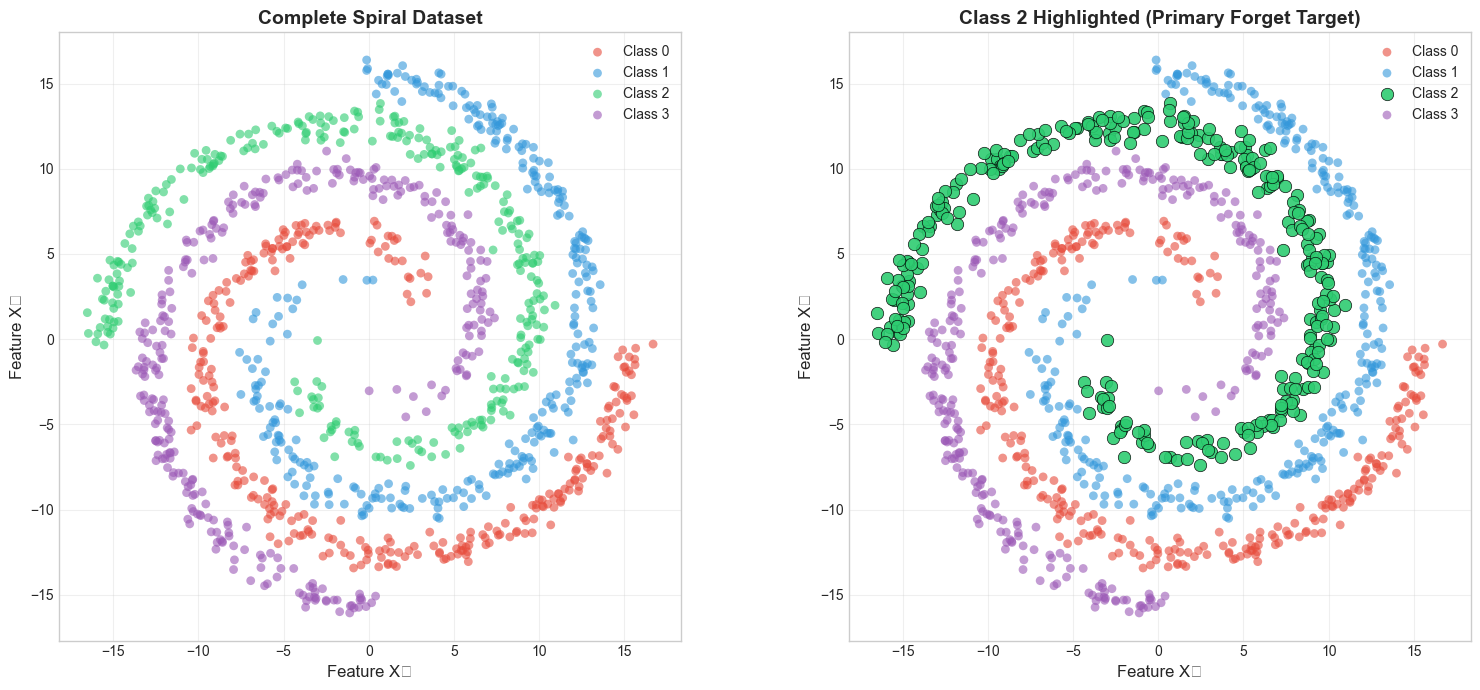


💡 Class 2 (green) will be our primary target for complete class unlearning.


In [38]:
def plot_spiral_dataset(
    X: np.ndarray, 
    y: np.ndarray, 
    title: str = "Spiral Dataset",
    highlight_class: Optional[int] = None,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Create a scatter plot of the spiral dataset.
    
    Args:
        X: Feature matrix (n_samples, 2)
        y: Labels (n_samples,)
        title: Plot title
        highlight_class: If specified, this class is highlighted with larger markers
        ax: Matplotlib axes to plot on (creates new figure if None)
    
    Returns:
        The matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    for class_idx in range(config.num_classes):
        mask = y == class_idx
        
        # Determine marker properties based on highlighting
        if highlight_class is not None and class_idx == highlight_class:
            size, alpha, edge = 80, 0.9, 'black'
        else:
            size, alpha, edge = 40, 0.6, 'none'
        
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=CLASS_COLORS[class_idx],
            label=f'Class {class_idx}',
            s=size,
            alpha=alpha,
            edgecolors=edge,
            linewidths=0.5
        )
    
    ax.set_xlabel('Feature X₁')
    ax.set_ylabel('Feature X₂')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    return ax


# Visualize the full dataset
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Full dataset
plot_spiral_dataset(X_full, y_full, "Complete Spiral Dataset", ax=axes[0])

# Right: Highlight Class 2 (our primary forget target)
plot_spiral_dataset(X_full, y_full, "Class 2 Highlighted (Primary Forget Target)", 
                   highlight_class=2, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n💡 Class 2 (green) will be our primary target for complete class unlearning.")

### 3.3 Train/Test Split and Normalization

In [39]:
# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================
# Stratified split ensures balanced class distribution in both sets

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    test_size=config.test_size,
    random_state=config.seed,
    stratify=y_full  # Maintain class proportions
)

print("="*60)
print("TRAIN/TEST SPLIT")
print("="*60)
print(f"Training set: {len(y_train):,} samples")
print(f"Test set: {len(y_test):,} samples")

# =============================================================================
# FEATURE NORMALIZATION
# =============================================================================
# StandardScaler: z = (x - μ) / σ
# Fitted ONLY on training data to prevent data leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform
X_test_scaled = scaler.transform(X_test)        # Transform only (no fitting!)

print(f"\nNormalization statistics (from training set):")
print(f"  Mean: [{scaler.mean_[0]:.4f}, {scaler.mean_[1]:.4f}]")
print(f"  Std:  [{scaler.scale_[0]:.4f}, {scaler.scale_[1]:.4f}]")

# Verify normalization
print(f"\nVerification (training set after scaling):")
print(f"  Mean: [{X_train_scaled[:, 0].mean():.6f}, {X_train_scaled[:, 1].mean():.6f}]")
print(f"  Std:  [{X_train_scaled[:, 0].std():.6f}, {X_train_scaled[:, 1].std():.6f}]")

TRAIN/TEST SPLIT
Training set: 960 samples
Test set: 240 samples

Normalization statistics (from training set):
  Mean: [0.2655, -0.0884]
  Std:  [8.3832, 8.3297]

Verification (training set after scaling):
  Mean: [0.000000, 0.000000]
  Std:  [1.000000, 1.000000]


### 3.4 Visualize Normalized Data

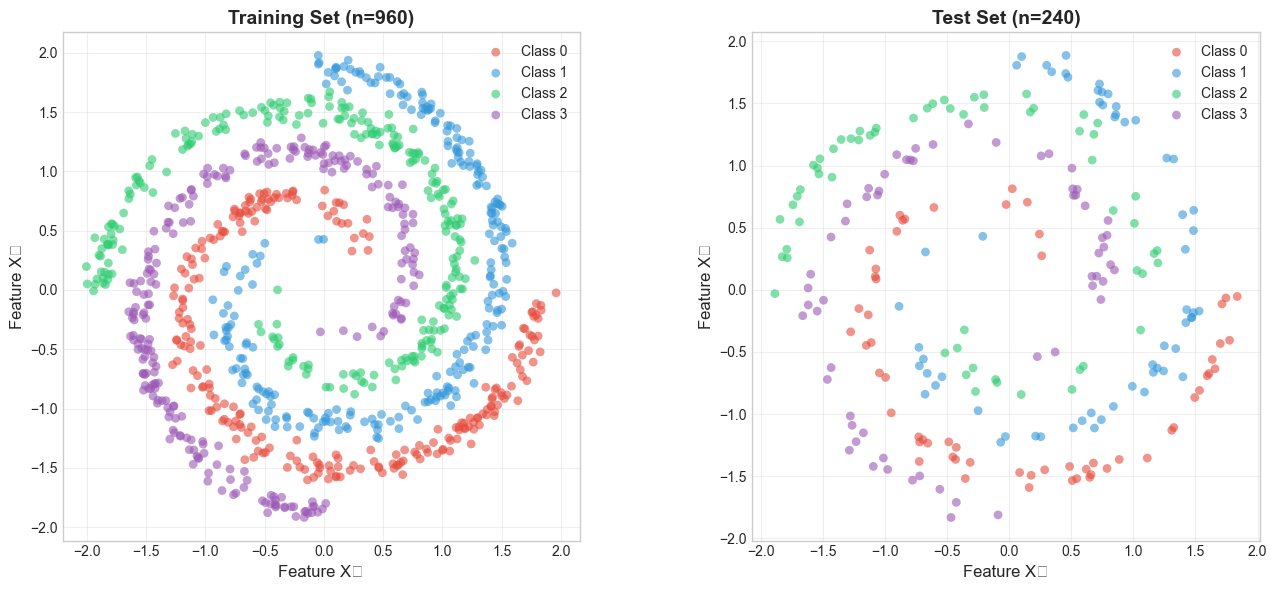

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
plot_spiral_dataset(X_train_scaled, y_train, 
                   f"Training Set (n={len(y_train)})", ax=axes[0])

# Test set
plot_spiral_dataset(X_test_scaled, y_test, 
                   f"Test Set (n={len(y_test)})", ax=axes[1])

plt.tight_layout()
plt.show()

---

<a id="4-baseline"></a>
## 4. Baseline Model Training

### 4.1 Why TabNet?

TabNet (Arik & Pfister, 2021) is a deep learning architecture specifically designed for tabular data. Key advantages include:

- **Interpretability:** Built-in attention mechanism shows which features are used for each decision
- **Sequential attention:** Decision-tree-like processing with learnable feature selection
- **No preprocessing required:** Handles numerical features directly
- **State-of-the-art performance:** Often matches or exceeds gradient boosting on tabular benchmarks

For machine unlearning research, TabNet provides clear access to network parameters through its PyTorch implementation, making noise injection straightforward.

In [41]:
def create_tabnet_model(config: ExperimentConfig, verbose: int = 1) -> TabNetClassifier:
    """
    Create a TabNet classifier with standardized configuration.
    
    Args:
        config: Experiment configuration dataclass
        verbose: Verbosity level (0=silent, 1=progress bar)
    
    Returns:
        Initialized TabNetClassifier (not yet fitted)
    """
    model = TabNetClassifier(
        # Architecture parameters
        n_d=config.n_d,                    # Decision prediction layer width
        n_a=config.n_a,                    # Attention embedding width
        n_steps=config.n_steps,            # Number of decision steps
        gamma=config.gamma,                # Feature reusage coefficient
        lambda_sparse=config.lambda_sparse, # Sparsity regularization
        
        # Optimizer configuration
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': config.learning_rate},
        
        # Learning rate scheduler
        scheduler_params={'step_size': 50, 'gamma': 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        
        # Mask type (entmax for sparse attention)
        mask_type='entmax',
        
        # Output control
        verbose=verbose
    )
    
    return model


def train_tabnet_model(
    model: TabNetClassifier,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray = None,
    y_val: np.ndarray = None,
    config: ExperimentConfig = None
) -> TabNetClassifier:
    """
    Train a TabNet model with early stopping.
    
    Args:
        model: Initialized TabNetClassifier
        X_train: Training features
        y_train: Training labels
        X_val: Validation features (optional)
        y_val: Validation labels (optional)
        config: Experiment configuration
    
    Returns:
        Trained TabNetClassifier
    """
    if config is None:
        config = ExperimentConfig()
    
    # Prepare validation set if provided
    eval_set = [(X_val, y_val)] if X_val is not None else None
    
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        max_epochs=config.max_epochs,
        patience=config.patience,
        batch_size=config.batch_size,
        virtual_batch_size=config.virtual_batch_size
    )
    
    return model


print("✓ Model creation functions defined")

✓ Model creation functions defined


### 4.2 Train the Baseline Model

In [42]:
print("="*60)
print("TRAINING BASELINE TABNET MODEL")
print("="*60)

# Create and train the model
start_time = time.time()

tabnet_model = create_tabnet_model(config, verbose=1)
tabnet_model = train_tabnet_model(
    tabnet_model,
    X_train_scaled, y_train.astype(int),
    X_test_scaled, y_test.astype(int),
    config
)

training_time = time.time() - start_time

# Evaluate baseline performance
y_train_pred = tabnet_model.predict(X_train_scaled)
y_test_pred = tabnet_model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n{'='*60}")
print("BASELINE MODEL PERFORMANCE")
print("="*60)
print(f"Training time: {training_time:.2f} seconds")
print(f"Training accuracy: {train_acc:.4f} ({train_acc:.1%})")
print(f"Test accuracy: {test_acc:.4f} ({test_acc:.1%})")

# Store baseline metrics for later comparison
baseline_metrics = {
    'train_acc': train_acc,
    'test_acc': test_acc,
    'training_time': training_time
}

TRAINING BASELINE TABNET MODEL
epoch 0  | loss: 2.2995  | val_0_accuracy: 0.2625  |  0:00:00s
epoch 1  | loss: 1.285   | val_0_accuracy: 0.25417 |  0:00:00s
epoch 2  | loss: 1.15649 | val_0_accuracy: 0.3125  |  0:00:00s
epoch 3  | loss: 1.07202 | val_0_accuracy: 0.32917 |  0:00:00s
epoch 4  | loss: 0.95743 | val_0_accuracy: 0.45417 |  0:00:00s
epoch 5  | loss: 0.90634 | val_0_accuracy: 0.4625  |  0:00:00s
epoch 6  | loss: 0.86463 | val_0_accuracy: 0.425   |  0:00:01s
epoch 7  | loss: 0.76903 | val_0_accuracy: 0.4125  |  0:00:01s
epoch 8  | loss: 0.73258 | val_0_accuracy: 0.44167 |  0:00:01s
epoch 9  | loss: 0.66296 | val_0_accuracy: 0.4375  |  0:00:01s
epoch 10 | loss: 0.61967 | val_0_accuracy: 0.4875  |  0:00:01s
epoch 11 | loss: 0.53114 | val_0_accuracy: 0.50417 |  0:00:01s
epoch 12 | loss: 0.5175  | val_0_accuracy: 0.5     |  0:00:01s
epoch 13 | loss: 0.46014 | val_0_accuracy: 0.54167 |  0:00:01s
epoch 14 | loss: 0.46931 | val_0_accuracy: 0.50417 |  0:00:01s
epoch 15 | loss: 0.39532

### 4.3 Baseline Model Evaluation

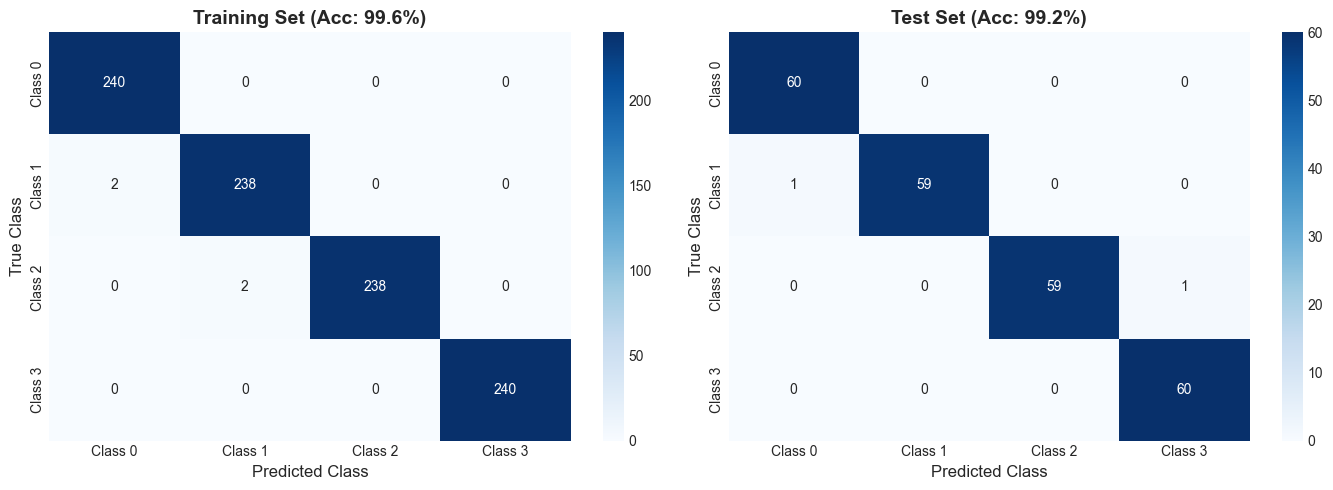


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

     Class 0       0.98      1.00      0.99        60
     Class 1       1.00      0.98      0.99        60
     Class 2       1.00      0.98      0.99        60
     Class 3       0.98      1.00      0.99        60

    accuracy                           0.99       240
   macro avg       0.99      0.99      0.99       240
weighted avg       0.99      0.99      0.99       240



In [43]:
def plot_confusion_matrix(
    y_true: np.ndarray, 
    y_pred: np.ndarray,
    title: str = "Confusion Matrix",
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Plot a confusion matrix with annotations.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        title: Plot title
        ax: Matplotlib axes (creates new if None)
    
    Returns:
        Matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[f'Class {i}' for i in range(config.num_classes)],
        yticklabels=[f'Class {i}' for i in range(config.num_classes)],
        ax=ax
    )
    
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('True Class')
    ax.set_title(title, fontweight='bold')
    
    return ax


# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_confusion_matrix(y_train, y_train_pred, 
                     f"Training Set (Acc: {train_acc:.1%})", ax=axes[0])
plot_confusion_matrix(y_test, y_test_pred, 
                     f"Test Set (Acc: {test_acc:.1%})", ax=axes[1])

plt.tight_layout()
plt.show()

# Detailed classification report
print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, 
                           target_names=[f'Class {i}' for i in range(config.num_classes)]))

### 4.4 Decision Boundary Visualization

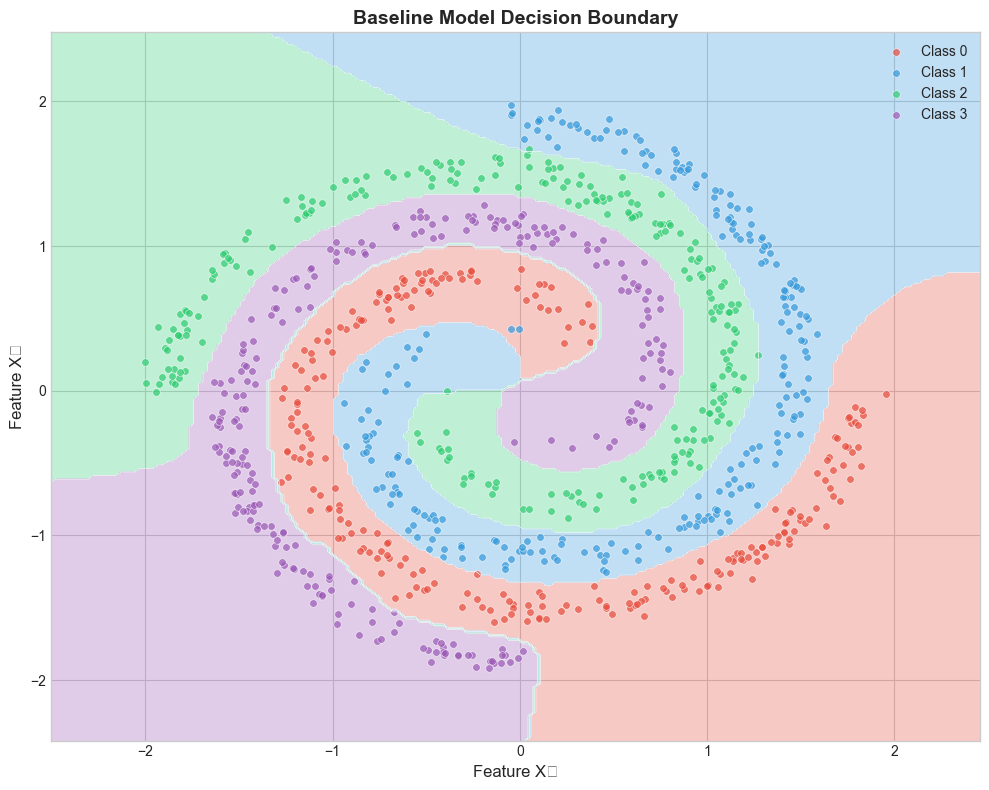


💡 The colored regions show where the model predicts each class.
   After unlearning Class 2, we expect the green region to disappear.


In [44]:
def plot_decision_boundary(
    model: TabNetClassifier,
    X: np.ndarray,
    y: np.ndarray,
    title: str = "Decision Boundary",
    resolution: int = 200,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    """
    Visualize the decision boundary of a classifier.
    
    Creates a mesh grid over the feature space and colors each
    region according to the model's predicted class.
    
    Args:
        model: Trained TabNetClassifier
        X: Feature matrix for scatter overlay
        y: Labels for scatter overlay
        title: Plot title
        resolution: Grid resolution (higher = smoother but slower)
        ax: Matplotlib axes (creates new if None)
    
    Returns:
        Matplotlib axes object
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    
    # Predict on mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Plot decision regions
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=CLASS_CMAP, levels=[-0.5, 0.5, 1.5, 2.5, 3.5])
    ax.contour(xx, yy, Z, colors='white', linewidths=0.5, levels=[0.5, 1.5, 2.5])
    
    # Overlay data points
    for class_idx in range(config.num_classes):
        mask = y == class_idx
        ax.scatter(
            X[mask, 0], X[mask, 1],
            c=CLASS_COLORS[class_idx],
            label=f'Class {class_idx}',
            s=30, alpha=0.7,
            edgecolors='white', linewidths=0.5
        )
    
    ax.set_xlabel('Feature X₁')
    ax.set_ylabel('Feature X₂')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    return ax


# Visualize decision boundary
fig, ax = plt.subplots(figsize=(10, 8))
plot_decision_boundary(
    tabnet_model, X_train_scaled, y_train,
    title="Baseline Model Decision Boundary",
    ax=ax
)
plt.tight_layout()
plt.show()

print("\n💡 The colored regions show where the model predicts each class.")
print("   After unlearning Class 2, we expect the green region to disappear.")

### 4.5 Feature Importance Analysis

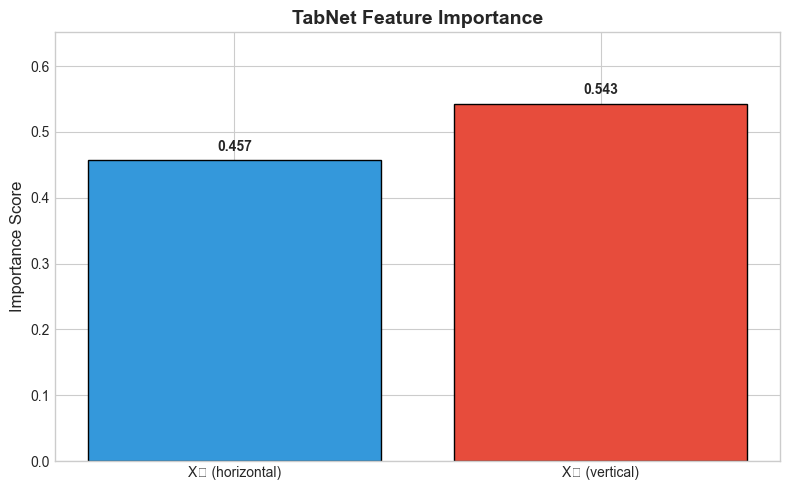


📊 Interpretation:
   Both features are important for spiral classification, as expected.
   The spiral pattern requires both X and Y coordinates to distinguish classes.


In [45]:
# TabNet provides built-in feature importance through attention masks
feature_importances = tabnet_model.feature_importances_

fig, ax = plt.subplots(figsize=(8, 5))

feature_names = ['X₁ (horizontal)', 'X₂ (vertical)']
colors = ['#3498DB', '#E74C3C']

bars = ax.bar(feature_names, feature_importances, color=colors, edgecolor='black')

# Add value labels on bars
for bar, imp in zip(bars, feature_importances):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{imp:.3f}', ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Importance Score')
ax.set_title('TabNet Feature Importance', fontweight='bold')
ax.set_ylim(0, max(feature_importances) * 1.2)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   Both features are important for spiral classification, as expected.")
print("   The spiral pattern requires both X and Y coordinates to distinguish classes.")

---

<a id="5-strategies"></a>
## 5. Unlearning Strategy Implementations

We implement five noise-based unlearning strategies, ordered by increasing sophistication:

1. **Gaussian Noise:** Simple isotropic noise injection
2. **Laplacian Noise:** Heavy-tailed noise for sharper disruption
3. **Adaptive Noise:** Magnitude-proportional noise targeting important parameters
4. **Layer-wise Noise:** Progressive noise with layer depth
5. **Gradient-based:** Data-aware gradient ascent with noise refinement

Each strategy returns a copy of the model to preserve the original for comparison.

In [46]:
# =============================================================================
# STRATEGY 1: GAUSSIAN NOISE INJECTION
# =============================================================================

def gaussian_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    noise_scale: float = 0.01,
    seed: int = 42
) -> TabNetClassifier:
    """
    Gaussian Noise Injection Unlearning.
    
    This is the simplest noise-based approach, adding Gaussian noise
    N(0, σ²) to all model parameters. The noise scale σ is proportional
    to each parameter's standard deviation, ensuring relative perturbation.
    
    Theoretical basis: Guo et al. (2020) showed that calibrated Gaussian
    noise provides (ε,δ)-certified removal guarantees.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused in this method)
        y_forget: Labels of data to forget (unused in this method)
        noise_scale: Multiplier for noise magnitude (relative to param std)
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    
    Note:
        X_forget and y_forget are included in the signature for API
        consistency with data-aware methods but are not used here.
    """
    # Create deep copy to preserve original model
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for param in unlearned.network.parameters():
            # Calculate parameter's standard deviation
            param_std = torch.std(param)
            
            if param_std > 0:
                # Generate Gaussian noise: N(0, (noise_scale * σ_param)²)
                noise = torch.randn_like(param) * noise_scale * param_std
                
                # Add noise to parameters in-place
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 1: Gaussian Noise Injection defined")

✓ Strategy 1: Gaussian Noise Injection defined


In [47]:
# =============================================================================
# STRATEGY 2: LAPLACIAN NOISE INJECTION
# =============================================================================

def laplacian_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    scale: float = 0.01,
    seed: int = 42
) -> TabNetClassifier:
    """
    Laplacian Noise Injection Unlearning.
    
    Uses Laplacian (double exponential) distribution instead of Gaussian.
    The Laplacian has heavier tails, meaning occasional large perturbations
    that can be more effective at disrupting memorized patterns.
    
    Laplacian PDF: f(x) = (1/2b) * exp(-|x|/b)
    
    Theoretical basis: Laplacian noise provides pure ε-differential privacy
    (without the δ term), which can be advantageous for privacy guarantees.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        scale: Scale parameter b for Laplacian distribution
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param).item()
            
            if param_std > 0:
                # Generate Laplacian noise using NumPy (PyTorch lacks native support)
                # Laplacian(0, scale * σ_param)
                noise_np = np.random.laplace(
                    loc=0, 
                    scale=scale * param_std, 
                    size=param.shape
                )
                
                # Convert to PyTorch tensor
                noise = torch.tensor(
                    noise_np, 
                    dtype=param.dtype, 
                    device=param.device
                )
                
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 2: Laplacian Noise Injection defined")

✓ Strategy 2: Laplacian Noise Injection defined


In [48]:
# =============================================================================
# STRATEGY 3: ADAPTIVE (MAGNITUDE-PROPORTIONAL) NOISE
# =============================================================================

def adaptive_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    noise_scale: float = 0.02,
    seed: int = 42
) -> TabNetClassifier:
    """
    Adaptive (Magnitude-Proportional) Noise Unlearning.
    
    The noise magnitude for each parameter is proportional to that
    parameter's absolute value. Larger weights (which typically encode
    more significant learned features) receive more noise.
    
    Intuition: Important connections (large weights) are more likely to
    store information about training data, so targeting them should be
    more effective for unlearning.
    
    This approach relates to SalUn (Fan et al., ICLR 2024), which uses
    gradient-based saliency to identify important parameters.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        noise_scale: Base scale for noise generation
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    with torch.no_grad():
        for param in unlearned.network.parameters():
            # Generate base noise
            base_noise = torch.randn_like(param) * noise_scale
            
            # Scale by parameter magnitude: |θ| * noise
            # Larger parameters receive proportionally more noise
            adaptive_noise = base_noise * torch.abs(param)
            
            param.add_(adaptive_noise)
    
    return unlearned


print("✓ Strategy 3: Adaptive Noise Injection defined")

✓ Strategy 3: Adaptive Noise Injection defined


In [49]:
# =============================================================================
# STRATEGY 4: LAYER-WISE PROGRESSIVE NOISE
# =============================================================================

def layerwise_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    base_scale: float = 0.01,
    scale_factor: float = 2.0,
    seed: int = 42
) -> TabNetClassifier:
    """
    Layer-wise Progressive Noise Unlearning.
    
    Applies different noise scales to different layers of the network.
    Earlier layers (feature extractors) receive less noise, while later
    layers (decision makers) receive more. This is based on the intuition
    that class-specific information is more concentrated in later layers.
    
    The noise scale progresses linearly from base_scale (first layer) to
    base_scale * scale_factor (last layer).
    
    This approach relates to "Layer Attack Unlearning" (Yoon et al., 2024),
    which found that targeting specific layers can improve unlearning.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (unused)
        y_forget: Labels of data to forget (unused)
        base_scale: Noise scale for the first layer
        scale_factor: Multiplier for final layer (noise increases linearly)
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    # Get all parameters as a list to determine total count
    params = list(unlearned.network.parameters())
    num_params = len(params)
    
    with torch.no_grad():
        for idx, param in enumerate(params):
            # Calculate progress through the network (0.0 to 1.0)
            layer_progress = idx / max(num_params - 1, 1)
            
            # Linear interpolation: base_scale → base_scale * scale_factor
            layer_scale = base_scale * (1 + layer_progress * (scale_factor - 1))
            
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * layer_scale * param_std
                param.add_(noise)
    
    return unlearned


print("✓ Strategy 4: Layer-wise Progressive Noise defined")

✓ Strategy 4: Layer-wise Progressive Noise defined


In [50]:
# =============================================================================
# STRATEGY 5: GRADIENT-BASED UNLEARNING WITH NOISE
# =============================================================================

def gradient_based_noise_unlearning(
    model: TabNetClassifier,
    X_forget: np.ndarray,
    y_forget: np.ndarray,
    lr: float = 0.002,
    steps: int = 2,
    noise_scale: float = 0.005,
    seed: int = 42
) -> TabNetClassifier:
    """
    Gradient-Based Unlearning with Noise Injection.
    
    This is the most sophisticated approach, combining two techniques:
    
    1. GRADIENT ASCENT: Perform gradient ASCENT (not descent) on the
       forget set. This actively pushes the model to perform WORSE on
       the forget data, effectively "inverting" what was learned.
       
       θ_new = θ + η * ∇L(θ, D_forget)  (note the + sign)
    
    2. NOISE INJECTION: After gradient ascent, add small Gaussian noise
       to prevent the model from simply learning the inverse pattern.
    
    This approach is based on "Descent-to-Delete" (Neel et al., ALT 2021)
    and relates to the "impair-repair" paradigm common in recent work.
    
    Args:
        model: Original trained TabNetClassifier
        X_forget: Features of data to forget (USED for gradient computation)
        y_forget: Labels of data to forget (USED for gradient computation)
        lr: Learning rate for gradient ascent (use smaller than training LR)
        steps: Number of gradient ascent steps (typically 2-5)
        noise_scale: Scale of Gaussian noise added after gradient ascent
        seed: Random seed for reproducibility
    
    Returns:
        New TabNetClassifier with perturbed parameters
    
    Warning:
        Too many steps or high learning rate can cause catastrophic forgetting
        where the model loses all learned knowledge, not just the forget set.
    """
    unlearned = copy.deepcopy(model)
    torch.manual_seed(seed)
    
    # Convert forget set to PyTorch tensors
    X_tensor = torch.FloatTensor(X_forget)
    y_tensor = torch.LongTensor(y_forget.astype(int))
    
    # Setup for gradient computation
    unlearned.network.train()  # Enable gradient tracking
    optimizer = torch.optim.SGD(unlearned.network.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    # =========================================================================
    # PHASE 1: GRADIENT ASCENT (IMPAIR)
    # =========================================================================
    for step in range(steps):
        optimizer.zero_grad()
        
        # Forward pass through the network
        output, _ = unlearned.network(X_tensor)
        
        # Compute cross-entropy loss
        loss = criterion(output, y_tensor)
        
        # KEY: Negate loss for gradient ASCENT
        # This maximizes loss, making the model worse at the forget set
        (-loss).backward()
        
        optimizer.step()
    
    # =========================================================================
    # PHASE 2: NOISE INJECTION (STABILIZE)
    # =========================================================================
    with torch.no_grad():
        for param in unlearned.network.parameters():
            param_std = torch.std(param)
            if param_std > 0:
                noise = torch.randn_like(param) * noise_scale * param_std
                param.add_(noise)
    
    unlearned.network.eval()  # Return to evaluation mode
    return unlearned


print("✓ Strategy 5: Gradient-Based Unlearning with Noise defined")

✓ Strategy 5: Gradient-Based Unlearning with Noise defined


In [51]:
# =============================================================================
# STRATEGY REGISTRY
# =============================================================================
# Centralized dictionary for easy iteration over all strategies

UNLEARNING_STRATEGIES = {
    'Gaussian': {
        'function': gaussian_noise_unlearning,
        'default_params': {'noise_scale': 0.01},
        'description': 'Isotropic Gaussian noise injection'
    },
    'Laplacian': {
        'function': laplacian_noise_unlearning,
        'default_params': {'scale': 0.01},
        'description': 'Heavy-tailed Laplacian noise injection'
    },
    'Adaptive': {
        'function': adaptive_noise_unlearning,
        'default_params': {'noise_scale': 0.02},
        'description': 'Magnitude-proportional noise injection'
    },
    'Layer-wise': {
        'function': layerwise_noise_unlearning,
        'default_params': {'base_scale': 0.01, 'scale_factor': 2.0},
        'description': 'Progressive noise with layer depth'
    },
    'Gradient-based': {
        'function': gradient_based_noise_unlearning,
        'default_params': {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005},
        'description': 'Gradient ascent with noise refinement'
    }
}

print("="*60)
print("UNLEARNING STRATEGIES SUMMARY")
print("="*60)
for name, info in UNLEARNING_STRATEGIES.items():
    print(f"\n{name}:")
    print(f"  Description: {info['description']}")
    print(f"  Default parameters: {info['default_params']}")

UNLEARNING STRATEGIES SUMMARY

Gaussian:
  Description: Isotropic Gaussian noise injection
  Default parameters: {'noise_scale': 0.01}

Laplacian:
  Description: Heavy-tailed Laplacian noise injection
  Default parameters: {'scale': 0.01}

Adaptive:
  Description: Magnitude-proportional noise injection
  Default parameters: {'noise_scale': 0.02}

Layer-wise:
  Description: Progressive noise with layer depth
  Default parameters: {'base_scale': 0.01, 'scale_factor': 2.0}

Gradient-based:
  Description: Gradient ascent with noise refinement
  Default parameters: {'lr': 0.002, 'steps': 2, 'noise_scale': 0.005}


---

<a id="6-experiments"></a>
## 6. Experimental Design: Forget Requests

We define three distinct "forget requests" that represent different real-world scenarios:

1. **FR1 - Complete Class Removal:** Remove all samples of Class 2 (simulates GDPR requests to remove all data from a specific category)

2. **FR2 - Partial Class Removal:** Remove 40% of Class 1 samples (simulates removing a subset of users who requested deletion)

3. **FR3 - Multi-Class Partial Removal:** Remove 40% of both Class 0 and Class 3 (simulates complex deletion patterns across categories)

In [52]:
@dataclass
class ForgetRequest:
    """Container for a forget request and its associated data splits."""
    name: str
    description: str
    X_retain: np.ndarray      # Features to keep
    y_retain: np.ndarray      # Labels to keep
    X_forget: np.ndarray      # Features to forget
    y_forget: np.ndarray      # Labels to forget
    X_test: np.ndarray        # Test features (original scaling)
    y_test: np.ndarray        # Test labels
    X_retain_baseline: np.ndarray  # Retain features rescaled for baseline
    X_test_baseline: np.ndarray    # Test features rescaled for baseline


def create_forget_requests(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    scaler: StandardScaler,
    rng: np.random.Generator
) -> Dict[str, ForgetRequest]:
    """
    Create all forget request scenarios.
    
    Each forget request includes:
    - Retain/Forget splits for the training set
    - Test set scaled with original scaler (for unlearning evaluation)
    - Retain set and test set rescaled (for baseline retraining)
    
    The rescaling for baseline is important: when we retrain from scratch
    on only the retain set, we should normalize using that data's statistics,
    not the original full training set statistics.
    
    Args:
        X_train: Original (unscaled) training features
        y_train: Training labels
        X_test: Original (unscaled) test features
        y_test: Test labels
        scaler: Fitted StandardScaler from original training
        rng: NumPy random generator
    
    Returns:
        Dictionary mapping forget request names to ForgetRequest objects
    """
    forget_requests = {}
    
    # =========================================================================
    # FR1: COMPLETE CLASS 2 REMOVAL
    # =========================================================================
    mask_class2 = y_train == 2
    
    X_retain_fr1 = X_train[~mask_class2]
    y_retain_fr1 = y_train[~mask_class2]
    X_forget_fr1 = X_train[mask_class2]
    y_forget_fr1 = y_train[mask_class2]
    
    # Scale with original scaler for unlearning comparison
    X_retain_fr1_scaled = scaler.transform(X_retain_fr1)
    X_forget_fr1_scaled = scaler.transform(X_forget_fr1)
    X_test_scaled = scaler.transform(X_test)
    
    # Rescale for baseline retraining
    scaler_fr1 = StandardScaler()
    X_retain_fr1_baseline = scaler_fr1.fit_transform(X_retain_fr1)
    X_test_fr1_baseline = scaler_fr1.transform(X_test)
    
    forget_requests['FR1: Remove Class 2'] = ForgetRequest(
        name='FR1',
        description='Complete removal of Class 2',
        X_retain=X_retain_fr1_scaled,
        y_retain=y_retain_fr1,
        X_forget=X_forget_fr1_scaled,
        y_forget=y_forget_fr1,
        X_test=X_test_scaled,
        y_test=y_test,
        X_retain_baseline=X_retain_fr1_baseline,
        X_test_baseline=X_test_fr1_baseline
    )
    
    # =========================================================================
    # FR2: PARTIAL CLASS 1 REMOVAL (40%)
    # =========================================================================
    class1_indices = np.where(y_train == 1)[0]
    n_forget = int(len(class1_indices) * 0.4)
    forget_indices_fr2 = rng.choice(class1_indices, n_forget, replace=False)
    
    mask_forget_fr2 = np.zeros(len(y_train), dtype=bool)
    mask_forget_fr2[forget_indices_fr2] = True
    
    X_retain_fr2 = X_train[~mask_forget_fr2]
    y_retain_fr2 = y_train[~mask_forget_fr2]
    X_forget_fr2 = X_train[mask_forget_fr2]
    y_forget_fr2 = y_train[mask_forget_fr2]
    
    X_retain_fr2_scaled = scaler.transform(X_retain_fr2)
    X_forget_fr2_scaled = scaler.transform(X_forget_fr2)
    
    scaler_fr2 = StandardScaler()
    X_retain_fr2_baseline = scaler_fr2.fit_transform(X_retain_fr2)
    X_test_fr2_baseline = scaler_fr2.transform(X_test)
    
    forget_requests['FR2: Trim Class 1 (40%)'] = ForgetRequest(
        name='FR2',
        description='Remove 40% of Class 1 samples',
        X_retain=X_retain_fr2_scaled,
        y_retain=y_retain_fr2,
        X_forget=X_forget_fr2_scaled,
        y_forget=y_forget_fr2,
        X_test=X_test_scaled,
        y_test=y_test,
        X_retain_baseline=X_retain_fr2_baseline,
        X_test_baseline=X_test_fr2_baseline
    )
    
    # =========================================================================
    # FR3: PARTIAL CLASSES 0 & 3 REMOVAL (40% EACH)
    # =========================================================================
    class0_indices = np.where(y_train == 0)[0]
    class3_indices = np.where(y_train == 3)[0]
    
    n_forget_0 = int(len(class0_indices) * 0.4)
    n_forget_3 = int(len(class3_indices) * 0.4)
    
    forget_indices_0 = rng.choice(class0_indices, n_forget_0, replace=False)
    forget_indices_3 = rng.choice(class3_indices, n_forget_3, replace=False)
    forget_indices_fr3 = np.concatenate([forget_indices_0, forget_indices_3])
    
    mask_forget_fr3 = np.zeros(len(y_train), dtype=bool)
    mask_forget_fr3[forget_indices_fr3] = True
    
    X_retain_fr3 = X_train[~mask_forget_fr3]
    y_retain_fr3 = y_train[~mask_forget_fr3]
    X_forget_fr3 = X_train[mask_forget_fr3]
    y_forget_fr3 = y_train[mask_forget_fr3]
    
    X_retain_fr3_scaled = scaler.transform(X_retain_fr3)
    X_forget_fr3_scaled = scaler.transform(X_forget_fr3)
    
    scaler_fr3 = StandardScaler()
    X_retain_fr3_baseline = scaler_fr3.fit_transform(X_retain_fr3)
    X_test_fr3_baseline = scaler_fr3.transform(X_test)
    
    forget_requests['FR3: Trim Classes 0&3 (40%)'] = ForgetRequest(
        name='FR3',
        description='Remove 40% of Classes 0 and 3',
        X_retain=X_retain_fr3_scaled,
        y_retain=y_retain_fr3,
        X_forget=X_forget_fr3_scaled,
        y_forget=y_forget_fr3,
        X_test=X_test_scaled,
        y_test=y_test,
        X_retain_baseline=X_retain_fr3_baseline,
        X_test_baseline=X_test_fr3_baseline
    )
    
    return forget_requests


# Create all forget requests
forget_requests = create_forget_requests(
    X_train, y_train, X_test, y_test, scaler, rng
)

print("="*60)
print("FORGET REQUESTS CREATED")
print("="*60)
for name, fr in forget_requests.items():
    print(f"\n{name}:")
    print(f"  Description: {fr.description}")
    print(f"  Retain samples: {len(fr.y_retain):,}")
    print(f"  Forget samples: {len(fr.y_forget):,}")
    print(f"  Forget ratio: {len(fr.y_forget) / (len(fr.y_retain) + len(fr.y_forget)):.1%}")

FORGET REQUESTS CREATED

FR1: Remove Class 2:
  Description: Complete removal of Class 2
  Retain samples: 720
  Forget samples: 240
  Forget ratio: 25.0%

FR2: Trim Class 1 (40%):
  Description: Remove 40% of Class 1 samples
  Retain samples: 864
  Forget samples: 96
  Forget ratio: 10.0%

FR3: Trim Classes 0&3 (40%):
  Description: Remove 40% of Classes 0 and 3
  Retain samples: 768
  Forget samples: 192
  Forget ratio: 20.0%


### 6.1 Visualize Forget Request Data Splits

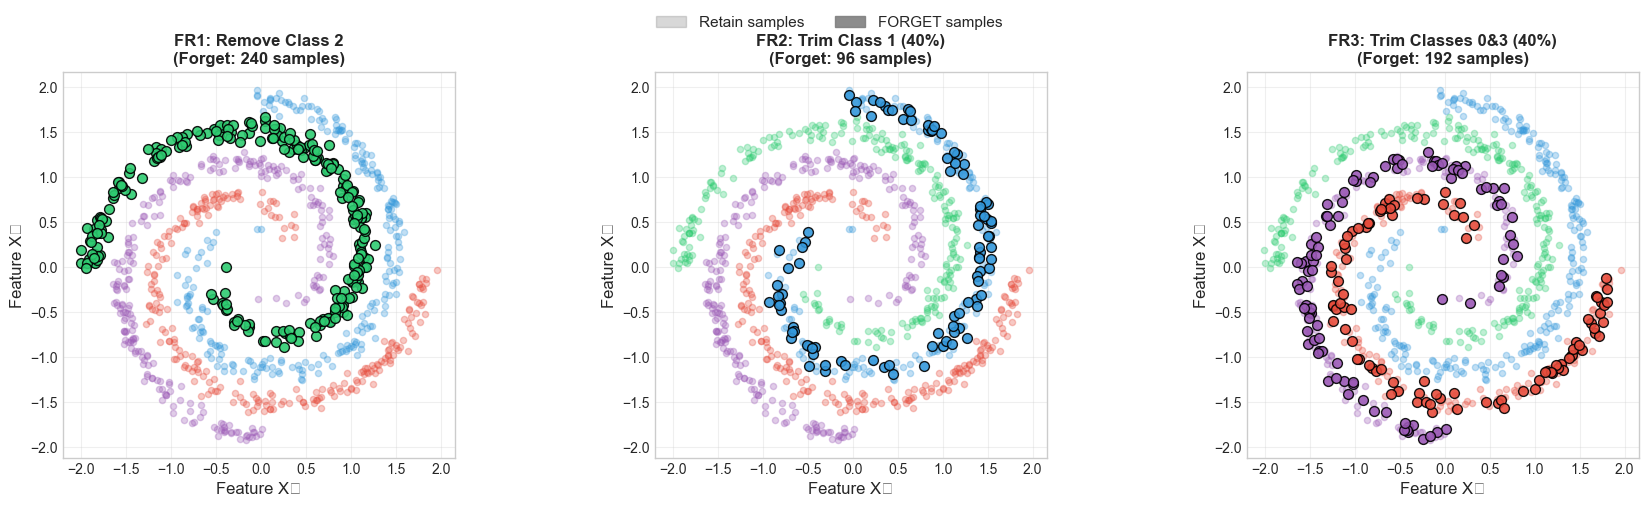


💡 Dark points with black edges are the samples to be forgotten.


In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, fr) in enumerate(forget_requests.items()):
    ax = axes[idx]
    
    # Plot retain samples (lighter)
    for class_idx in range(config.num_classes):
        mask = fr.y_retain == class_idx
        if mask.any():
            ax.scatter(
                fr.X_retain[mask, 0], fr.X_retain[mask, 1],
                c=CLASS_COLORS[class_idx],
                alpha=0.3, s=20,
                label=f'Retain Class {class_idx}'
            )
    
    # Plot forget samples (darker, with edge)
    for class_idx in range(config.num_classes):
        mask = fr.y_forget == class_idx
        if mask.any():
            ax.scatter(
                fr.X_forget[mask, 0], fr.X_forget[mask, 1],
                c=CLASS_COLORS[class_idx],
                alpha=0.9, s=50,
                edgecolors='black', linewidths=1,
                label=f'FORGET Class {class_idx}'
            )
    
    ax.set_title(f"{name}\n(Forget: {len(fr.y_forget)} samples)", 
                fontweight='bold', fontsize=12)
    ax.set_xlabel('Feature X₁')
    ax.set_ylabel('Feature X₂')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

# Add shared legend
handles = [
    mpatches.Patch(color='gray', alpha=0.3, label='Retain samples'),
    mpatches.Patch(color='gray', alpha=0.9, label='FORGET samples')
]
fig.legend(handles=handles, loc='upper center', ncol=2, 
          bbox_to_anchor=(0.5, 1.02), fontsize=11)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print("\n💡 Dark points with black edges are the samples to be forgotten.")

---

<a id="7-evaluation"></a>
## 7. Comprehensive Evaluation

### 7.1 Evaluation Metrics

We evaluate unlearning quality using multiple complementary metrics:

In [54]:
@dataclass
class UnlearningMetrics:
    """Container for all unlearning evaluation metrics."""
    retain_accuracy: float      # Accuracy on retain set (higher = better)
    forget_accuracy: float      # Accuracy on forget set (lower = better)
    test_accuracy: float        # Accuracy on test set (higher = better)
    mia_auc: float             # MIA attack AUC (closer to 0.5 = better)
    param_distance: float       # L2 distance from original model
    balance_score: float        # Combined metric: retain + test - forget
    unlearning_time: float      # Time taken for unlearning (seconds)


def compute_mia_vulnerability(
    model: TabNetClassifier,
    X_members: np.ndarray,
    X_non_members: np.ndarray
) -> float:
    """
    Compute Membership Inference Attack (MIA) vulnerability.
    
    MIA tests whether an adversary can determine if a sample was in
    the training set based on the model's prediction confidence.
    
    We use a simple threshold-based attack:
    - Compute max prediction probability for each sample
    - Members (training data) typically have higher confidence
    - Non-members have lower confidence
    
    The AUC measures how well these can be distinguished:
    - AUC = 0.5: Random guessing (no information leakage) ✓
    - AUC = 1.0: Perfect attack (complete information leakage) ✗
    
    For successful unlearning, forget set AUC should approach 0.5.
    
    Args:
        model: Trained TabNetClassifier
        X_members: Features of samples that WERE in training
        X_non_members: Features of samples that were NOT in training
    
    Returns:
        AUC score for the membership inference attack
    """
    # Get prediction probabilities
    proba_members = model.predict_proba(X_members)
    proba_non_members = model.predict_proba(X_non_members)
    
    # Use max probability as membership signal
    confidence_members = np.max(proba_members, axis=1)
    confidence_non_members = np.max(proba_non_members, axis=1)
    
    # Combine into attack dataset
    confidences = np.concatenate([confidence_members, confidence_non_members])
    labels = np.concatenate([
        np.ones(len(confidence_members)),   # 1 = member
        np.zeros(len(confidence_non_members))  # 0 = non-member
    ])
    
    # Compute AUC (handle edge cases)
    try:
        auc = roc_auc_score(labels, confidences)
    except ValueError:
        auc = 0.5  # Default to random if computation fails
    
    return auc


def compute_parameter_distance(
    model1: TabNetClassifier,
    model2: TabNetClassifier
) -> float:
    """
    Compute L2 distance between two models' parameters.
    
    This measures how much the unlearning process changed the model.
    Smaller distance from a retrained model indicates better unlearning.
    
    Args:
        model1: First TabNetClassifier
        model2: Second TabNetClassifier
    
    Returns:
        L2 norm of parameter difference
    """
    total_distance = 0.0
    
    params1 = list(model1.network.parameters())
    params2 = list(model2.network.parameters())
    
    for p1, p2 in zip(params1, params2):
        diff = (p1 - p2).detach().cpu().numpy()
        total_distance += np.sum(diff ** 2)
    
    return np.sqrt(total_distance)


def evaluate_unlearning(
    model: TabNetClassifier,
    original_model: TabNetClassifier,
    fr: ForgetRequest,
    unlearning_time: float = 0.0
) -> UnlearningMetrics:
    """
    Compute all evaluation metrics for an unlearned model.
    
    Args:
        model: Unlearned TabNetClassifier
        original_model: Original trained model (for parameter distance)
        fr: ForgetRequest with data splits
        unlearning_time: Time taken for unlearning
    
    Returns:
        UnlearningMetrics dataclass with all computed metrics
    """
    # Accuracy metrics
    retain_acc = accuracy_score(fr.y_retain, model.predict(fr.X_retain))
    forget_acc = accuracy_score(fr.y_forget, model.predict(fr.X_forget))
    test_acc = accuracy_score(fr.y_test, model.predict(fr.X_test))
    
    # MIA vulnerability (using test set as non-members)
    mia_auc = compute_mia_vulnerability(model, fr.X_forget, fr.X_test)
    
    # Parameter distance from original
    param_dist = compute_parameter_distance(model, original_model)
    
    # Balance score: higher is better
    balance = retain_acc + test_acc - forget_acc
    
    return UnlearningMetrics(
        retain_accuracy=retain_acc,
        forget_accuracy=forget_acc,
        test_accuracy=test_acc,
        mia_auc=mia_auc,
        param_distance=param_dist,
        balance_score=balance,
        unlearning_time=unlearning_time
    )


print("✓ Evaluation functions defined")

✓ Evaluation functions defined


### 7.2 Baseline Retraining (Gold Standard)

The gold standard for unlearning is retraining from scratch on only the retain set. This provides the target behavior that approximate unlearning methods aim to match.

In [55]:
def train_baseline_model(
    fr: ForgetRequest,
    config: ExperimentConfig
) -> Tuple[TabNetClassifier, float]:
    """
    Train a baseline model from scratch on only the retain set.
    
    This is the "gold standard" for unlearning: a model that never
    saw the forget data in the first place.
    
    Args:
        fr: ForgetRequest with data splits
        config: Experiment configuration
    
    Returns:
        Tuple of (trained model, training time)
    """
    start_time = time.time()
    
    model = create_tabnet_model(config, verbose=0)
    model.fit(
        fr.X_retain_baseline, 
        fr.y_retain.astype(int),
        max_epochs=config.max_epochs,
        patience=config.patience,
        batch_size=config.batch_size,
        virtual_batch_size=config.virtual_batch_size
    )
    
    training_time = time.time() - start_time
    return model, training_time


# Train baseline models for each forget request
print("="*60)
print("TRAINING BASELINE MODELS (GOLD STANDARD)")
print("="*60)
print("\nThis simulates 'perfect' unlearning by retraining from scratch.\n")

baseline_models = {}
baseline_metrics_dict = {}

for name, fr in tqdm(forget_requests.items(), desc="Training baselines"):
    model, train_time = train_baseline_model(fr, config)
    baseline_models[name] = model
    
    # Evaluate on rescaled data (for fair comparison)
    # Note: Baseline uses its own scaler, so we need to be careful
    retain_acc = accuracy_score(
        fr.y_retain, 
        model.predict(fr.X_retain_baseline)
    )
    test_acc = accuracy_score(
        fr.y_test, 
        model.predict(fr.X_test_baseline)
    )
    # For forget accuracy, we need to rescale forget set with baseline scaler
    # But we don't have access to it, so we skip for now and use test as proxy
    
    baseline_metrics_dict[name] = {
        'retain': retain_acc,
        'test': test_acc,
        'time': train_time
    }
    
    print(f"\n{name}:")
    print(f"  Retain accuracy: {retain_acc:.4f}")
    print(f"  Test accuracy: {test_acc:.4f}")
    print(f"  Training time: {train_time:.2f}s")

TRAINING BASELINE MODELS (GOLD STANDARD)

This simulates 'perfect' unlearning by retraining from scratch.



Training baselines:  33%|███▎      | 1/3 [00:05<00:11,  5.62s/it]


FR1: Remove Class 2:
  Retain accuracy: 0.9944
  Test accuracy: 0.7417
  Training time: 5.58s


Training baselines:  67%|██████▋   | 2/3 [00:15<00:08,  8.23s/it]


FR2: Trim Class 1 (40%):
  Retain accuracy: 0.9896
  Test accuracy: 0.9708
  Training time: 9.97s


Training baselines: 100%|██████████| 3/3 [00:29<00:00,  9.93s/it]


FR3: Trim Classes 0&3 (40%):
  Retain accuracy: 0.9974
  Test accuracy: 0.9875
  Training time: 14.04s


### 7.3 Run All Unlearning Experiments

In [56]:
def run_unlearning_experiment(
    original_model: TabNetClassifier,
    strategy_name: str,
    strategy_info: dict,
    fr: ForgetRequest,
    seed: int = 42
) -> Tuple[TabNetClassifier, UnlearningMetrics]:
    """
    Run a single unlearning experiment.
    
    Args:
        original_model: The trained model to unlearn from
        strategy_name: Name of the strategy
        strategy_info: Dictionary with function and default params
        fr: ForgetRequest with data splits
        seed: Random seed
    
    Returns:
        Tuple of (unlearned model, metrics)
    """
    unlearn_fn = strategy_info['function']
    params = strategy_info['default_params'].copy()
    params['seed'] = seed
    
    # Time the unlearning process
    start_time = time.time()
    unlearned_model = unlearn_fn(
        original_model, 
        fr.X_forget, 
        fr.y_forget,
        **params
    )
    unlearning_time = time.time() - start_time
    
    # Evaluate
    metrics = evaluate_unlearning(
        unlearned_model, 
        original_model, 
        fr,
        unlearning_time
    )
    
    return unlearned_model, metrics


# Run all experiments
print("="*60)
print("RUNNING UNLEARNING EXPERIMENTS")
print("="*60)
print(f"\nTotal experiments: {len(forget_requests)} × {len(UNLEARNING_STRATEGIES)} = "
      f"{len(forget_requests) * len(UNLEARNING_STRATEGIES)}\n")

all_results = {}  # {forget_request: {strategy: metrics}}
all_models = {}   # {forget_request: {strategy: model}}

for fr_name, fr in forget_requests.items():
    print(f"\n{'='*60}")
    print(f"Processing: {fr_name}")
    print(f"{'='*60}")
    
    all_results[fr_name] = {}
    all_models[fr_name] = {}
    
    for strategy_name, strategy_info in UNLEARNING_STRATEGIES.items():
        model, metrics = run_unlearning_experiment(
            tabnet_model,
            strategy_name,
            strategy_info,
            fr,
            config.seed
        )
        
        all_results[fr_name][strategy_name] = metrics
        all_models[fr_name][strategy_name] = model
        
        # Print summary
        status = "✓" if metrics.forget_accuracy < 0.4 else "✗"
        print(f"  {strategy_name:15s} | Retain: {metrics.retain_accuracy:.3f} | "
              f"Forget: {metrics.forget_accuracy:.3f} | "
              f"Test: {metrics.test_accuracy:.3f} | "
              f"MIA: {metrics.mia_auc:.3f} | {status}")

print(f"\n{'='*60}")
print("✓ All experiments completed!")
print(f"{'='*60}")

RUNNING UNLEARNING EXPERIMENTS

Total experiments: 3 × 5 = 15


Processing: FR1: Remove Class 2
  Gaussian        | Retain: 0.997 | Forget: 0.996 | Test: 0.992 | MIA: 0.528 | ✗
  Laplacian       | Retain: 0.996 | Forget: 0.992 | Test: 0.992 | MIA: 0.507 | ✗
  Adaptive        | Retain: 0.992 | Forget: 0.996 | Test: 0.983 | MIA: 0.545 | ✗
  Layer-wise      | Retain: 0.997 | Forget: 0.996 | Test: 0.996 | MIA: 0.544 | ✗
  Gradient-based  | Retain: 0.997 | Forget: 0.996 | Test: 0.988 | MIA: 0.466 | ✗

Processing: FR2: Trim Class 1 (40%)
  Gaussian        | Retain: 0.997 | Forget: 1.000 | Test: 0.992 | MIA: 0.460 | ✗
  Laplacian       | Retain: 0.994 | Forget: 1.000 | Test: 0.992 | MIA: 0.479 | ✗
  Adaptive        | Retain: 0.992 | Forget: 1.000 | Test: 0.983 | MIA: 0.434 | ✗
  Layer-wise      | Retain: 0.997 | Forget: 1.000 | Test: 0.996 | MIA: 0.453 | ✗
  Gradient-based  | Retain: 0.997 | Forget: 1.000 | Test: 0.988 | MIA: 0.459 | ✗

Processing: FR3: Trim Classes 0&3 (40%)
  Gaussian      

---

<a id="8-optimization"></a>
## 8. Hyperparameter Optimization

We perform a grid search to find optimal hyperparameters for each strategy.

In [57]:
# Define parameter grids for each strategy
PARAM_GRIDS = {
    'Gaussian': {
        'noise_scale': [0.005, 0.01, 0.02, 0.05, 0.1]
    },
    'Laplacian': {
        'scale': [0.005, 0.01, 0.02, 0.05, 0.1]
    },
    'Adaptive': {
        'noise_scale': [0.01, 0.02, 0.05, 0.1, 0.2]
    },
    'Layer-wise': {
        'base_scale': [0.005, 0.01, 0.02],
        'scale_factor': [1.5, 2.0, 3.0]
    },
    'Gradient-based': {
        'lr': [0.001, 0.002, 0.005],
        'steps': [1, 2, 3, 5],
        'noise_scale': [0.001, 0.005, 0.01]
    }
}


def grid_search_strategy(
    original_model: TabNetClassifier,
    strategy_name: str,
    param_grid: dict,
    fr: ForgetRequest,
    seed: int = 42
) -> Tuple[dict, UnlearningMetrics]:
    """
    Perform grid search for optimal hyperparameters.
    
    Uses balance_score (retain + test - forget) as the optimization target.
    
    Args:
        original_model: Trained model to unlearn from
        strategy_name: Name of the strategy
        param_grid: Dictionary of parameter names to value lists
        fr: ForgetRequest with data splits
        seed: Random seed
    
    Returns:
        Tuple of (best_params, best_metrics)
    """
    import itertools
    
    unlearn_fn = UNLEARNING_STRATEGIES[strategy_name]['function']
    
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    
    best_score = -float('inf')
    best_params = None
    best_metrics = None
    
    for combo in itertools.product(*param_values):
        params = dict(zip(param_names, combo))
        params['seed'] = seed
        
        # Run unlearning
        start_time = time.time()
        unlearned = unlearn_fn(original_model, fr.X_forget, fr.y_forget, **params)
        unlearn_time = time.time() - start_time
        
        # Evaluate
        metrics = evaluate_unlearning(unlearned, original_model, fr, unlearn_time)
        
        # Check if best
        if metrics.balance_score > best_score:
            best_score = metrics.balance_score
            best_params = {k: v for k, v in params.items() if k != 'seed'}
            best_metrics = metrics
    
    return best_params, best_metrics


# Run hyperparameter optimization (only on FR1 for time efficiency)
print("="*60)
print("HYPERPARAMETER OPTIMIZATION")
print("="*60)
print("\nOptimizing on FR1: Remove Class 2 (primary use case)\n")

fr_optimize = forget_requests['FR1: Remove Class 2']
best_configs = {}

for strategy_name, param_grid in tqdm(PARAM_GRIDS.items(), desc="Optimizing"):
    best_params, best_metrics = grid_search_strategy(
        tabnet_model,
        strategy_name,
        param_grid,
        fr_optimize,
        config.seed
    )
    
    best_configs[strategy_name] = {
        'params': best_params,
        'metrics': best_metrics
    }
    
    print(f"\n{strategy_name}:")
    print(f"  Best params: {best_params}")
    print(f"  Balance score: {best_metrics.balance_score:.4f}")
    print(f"  Retain: {best_metrics.retain_accuracy:.3f} | "
          f"Forget: {best_metrics.forget_accuracy:.3f} | "
          f"Test: {best_metrics.test_accuracy:.3f}")

HYPERPARAMETER OPTIMIZATION

Optimizing on FR1: Remove Class 2 (primary use case)



Optimizing:  20%|██        | 1/5 [00:00<00:03,  1.31it/s]


Gaussian:
  Best params: {'noise_scale': 0.005}
  Balance score: 0.9972
  Retain: 0.997 | Forget: 0.992 | Test: 0.992


Optimizing:  40%|████      | 2/5 [00:01<00:02,  1.23it/s]


Laplacian:
  Best params: {'scale': 0.005}
  Balance score: 0.9972
  Retain: 0.997 | Forget: 0.992 | Test: 0.992


Optimizing:  60%|██████    | 3/5 [00:02<00:01,  1.19it/s]


Adaptive:
  Best params: {'noise_scale': 0.01}
  Balance score: 0.9875
  Retain: 0.996 | Forget: 0.996 | Test: 0.988


Optimizing:  80%|████████  | 4/5 [00:04<00:01,  1.44s/it]


Layer-wise:
  Best params: {'base_scale': 0.005, 'scale_factor': 3.0}
  Balance score: 1.0014
  Retain: 0.997 | Forget: 0.992 | Test: 0.996


Optimizing: 100%|██████████| 5/5 [00:11<00:00,  2.38s/it]


Gradient-based:
  Best params: {'lr': 0.005, 'steps': 3, 'noise_scale': 0.001}
  Balance score: 0.9986
  Retain: 0.986 | Forget: 0.971 | Test: 0.983


---

<a id="9-results"></a>
## 9. Results Analysis & Visualization

### 9.1 Results Summary Table

In [58]:
def create_results_dataframe(all_results: dict) -> pd.DataFrame:
    """
    Create a pandas DataFrame from the results dictionary.
    
    Args:
        all_results: Nested dictionary of results
    
    Returns:
        DataFrame with all metrics
    """
    rows = []
    
    for fr_name, strategies in all_results.items():
        for strategy_name, metrics in strategies.items():
            rows.append({
                'Forget Request': fr_name,
                'Strategy': strategy_name,
                'Retain Acc': metrics.retain_accuracy,
                'Forget Acc': metrics.forget_accuracy,
                'Test Acc': metrics.test_accuracy,
                'MIA AUC': metrics.mia_auc,
                'Param Distance': metrics.param_distance,
                'Balance Score': metrics.balance_score,
                'Time (s)': metrics.unlearning_time
            })
    
    return pd.DataFrame(rows)


# Create and display results table
results_df = create_results_dataframe(all_results)

print("="*100)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*100)

# Format for display
display_df = results_df.copy()
display_df['Retain Acc'] = display_df['Retain Acc'].map('{:.3f}'.format)
display_df['Forget Acc'] = display_df['Forget Acc'].map('{:.3f}'.format)
display_df['Test Acc'] = display_df['Test Acc'].map('{:.3f}'.format)
display_df['MIA AUC'] = display_df['MIA AUC'].map('{:.3f}'.format)
display_df['Balance Score'] = display_df['Balance Score'].map('{:.3f}'.format)
display_df['Time (s)'] = display_df['Time (s)'].map('{:.4f}'.format)

print(display_df.to_string(index=False))

COMPREHENSIVE RESULTS SUMMARY
             Forget Request       Strategy Retain Acc Forget Acc Test Acc MIA AUC  Param Distance Balance Score Time (s)
        FR1: Remove Class 2       Gaussian      0.997      0.996    0.992   0.528        0.538116         0.993   0.0887
        FR1: Remove Class 2      Laplacian      0.996      0.992    0.992   0.507        0.768044         0.996   0.0502
        FR1: Remove Class 2       Adaptive      0.992      0.996    0.983   0.545        1.217933         0.979   0.0566
        FR1: Remove Class 2     Layer-wise      0.997      0.996    0.996   0.544        0.788099         0.997   0.0441
        FR1: Remove Class 2 Gradient-based      0.997      0.996    0.988   0.466        0.270881         0.989   0.1012
    FR2: Trim Class 1 (40%)       Gaussian      0.997      1.000    0.992   0.460        0.538116         0.988   0.1205
    FR2: Trim Class 1 (40%)      Laplacian      0.994      1.000    0.992   0.479        0.768044         0.986   0.0498
  

### 9.2 Heatmap Visualization

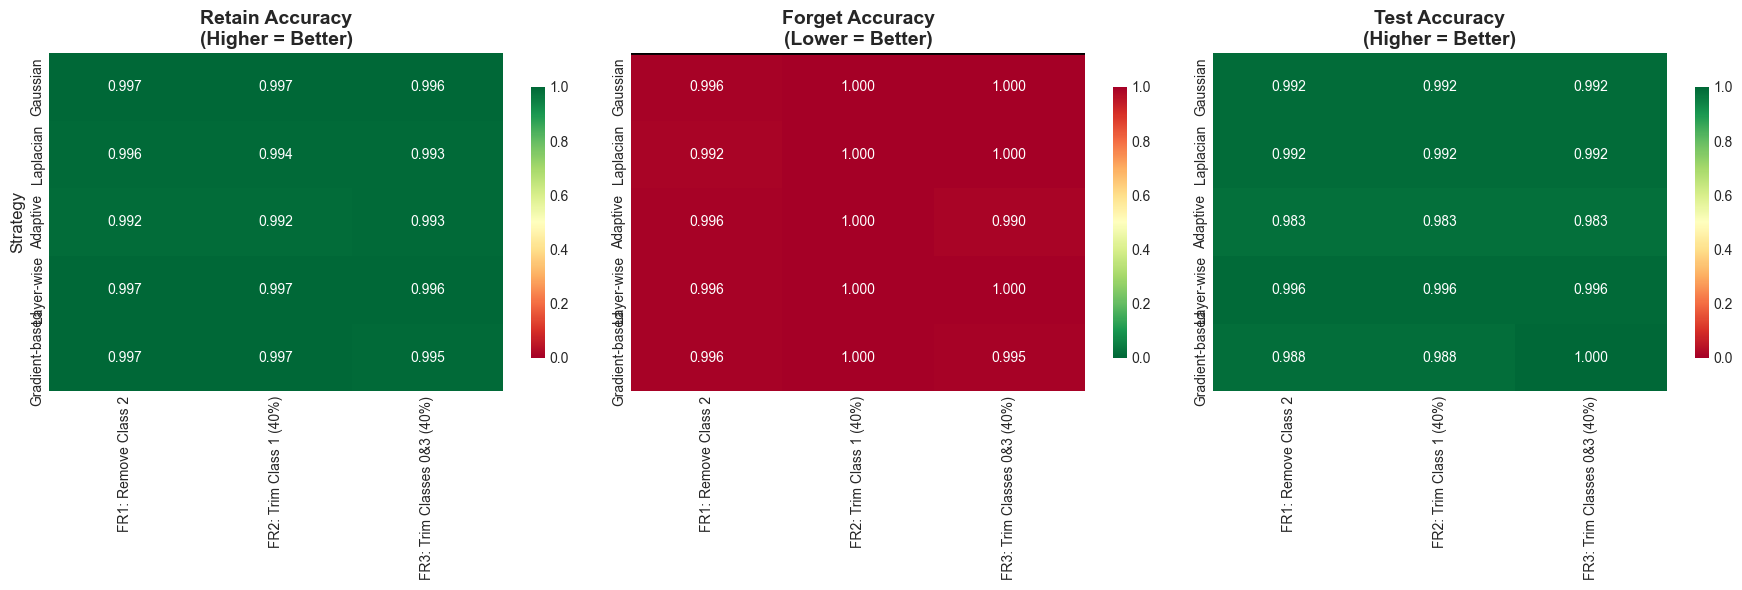


📊 Interpretation Guide:
  • Target Forget Accuracy: 25% (random guessing)
  • Target Retain Accuracy: >90%
  • Target MIA AUC: ~50% (no information leakage)


In [59]:
def plot_metrics_heatmaps(results_df: pd.DataFrame) -> None:
    """
    Create heatmap visualizations for all metrics.
    
    Args:
        results_df: DataFrame with results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    strategies = results_df['Strategy'].unique()
    forget_requests = results_df['Forget Request'].unique()
    
    # Pivot tables for each metric
    retain_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Retain Acc'
    ).reindex(strategies)
    
    forget_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Forget Acc'
    ).reindex(strategies)
    
    test_pivot = results_df.pivot(
        index='Strategy', columns='Forget Request', values='Test Acc'
    ).reindex(strategies)
    
    # Plot 1: Retain Accuracy (higher = better = green)
    sns.heatmap(
        retain_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
        vmin=0.0, vmax=1.0, ax=axes[0], cbar_kws={'shrink': 0.8}
    )
    axes[0].set_title('Retain Accuracy\n(Higher = Better)', fontweight='bold')
    axes[0].set_ylabel('Strategy')
    axes[0].set_xlabel('')
    
    # Plot 2: Forget Accuracy (lower = better = reversed colormap)
    sns.heatmap(
        forget_pivot, annot=True, fmt='.3f', cmap='RdYlGn_r',
        vmin=0.0, vmax=1.0, ax=axes[1], cbar_kws={'shrink': 0.8}
    )
    axes[1].set_title('Forget Accuracy\n(Lower = Better)', fontweight='bold')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('')
    # Add target line annotation
    axes[1].axhline(y=0, color='black', linewidth=2)
    
    # Plot 3: Test Accuracy (higher = better)
    sns.heatmap(
        test_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
        vmin=0.0, vmax=1.0, ax=axes[2], cbar_kws={'shrink': 0.8}
    )
    axes[2].set_title('Test Accuracy\n(Higher = Better)', fontweight='bold')
    axes[2].set_ylabel('')
    axes[2].set_xlabel('')
    
    plt.tight_layout()
    plt.show()


plot_metrics_heatmaps(results_df)

print("\n📊 Interpretation Guide:")
print(f"  • Target Forget Accuracy: {config.target_forget_accuracy:.0%} (random guessing)")
print(f"  • Target Retain Accuracy: >{config.target_retain_accuracy:.0%}")
print(f"  • Target MIA AUC: ~{config.target_mia_auc:.0%} (no information leakage)")

### 9.3 Decision Boundary Comparison

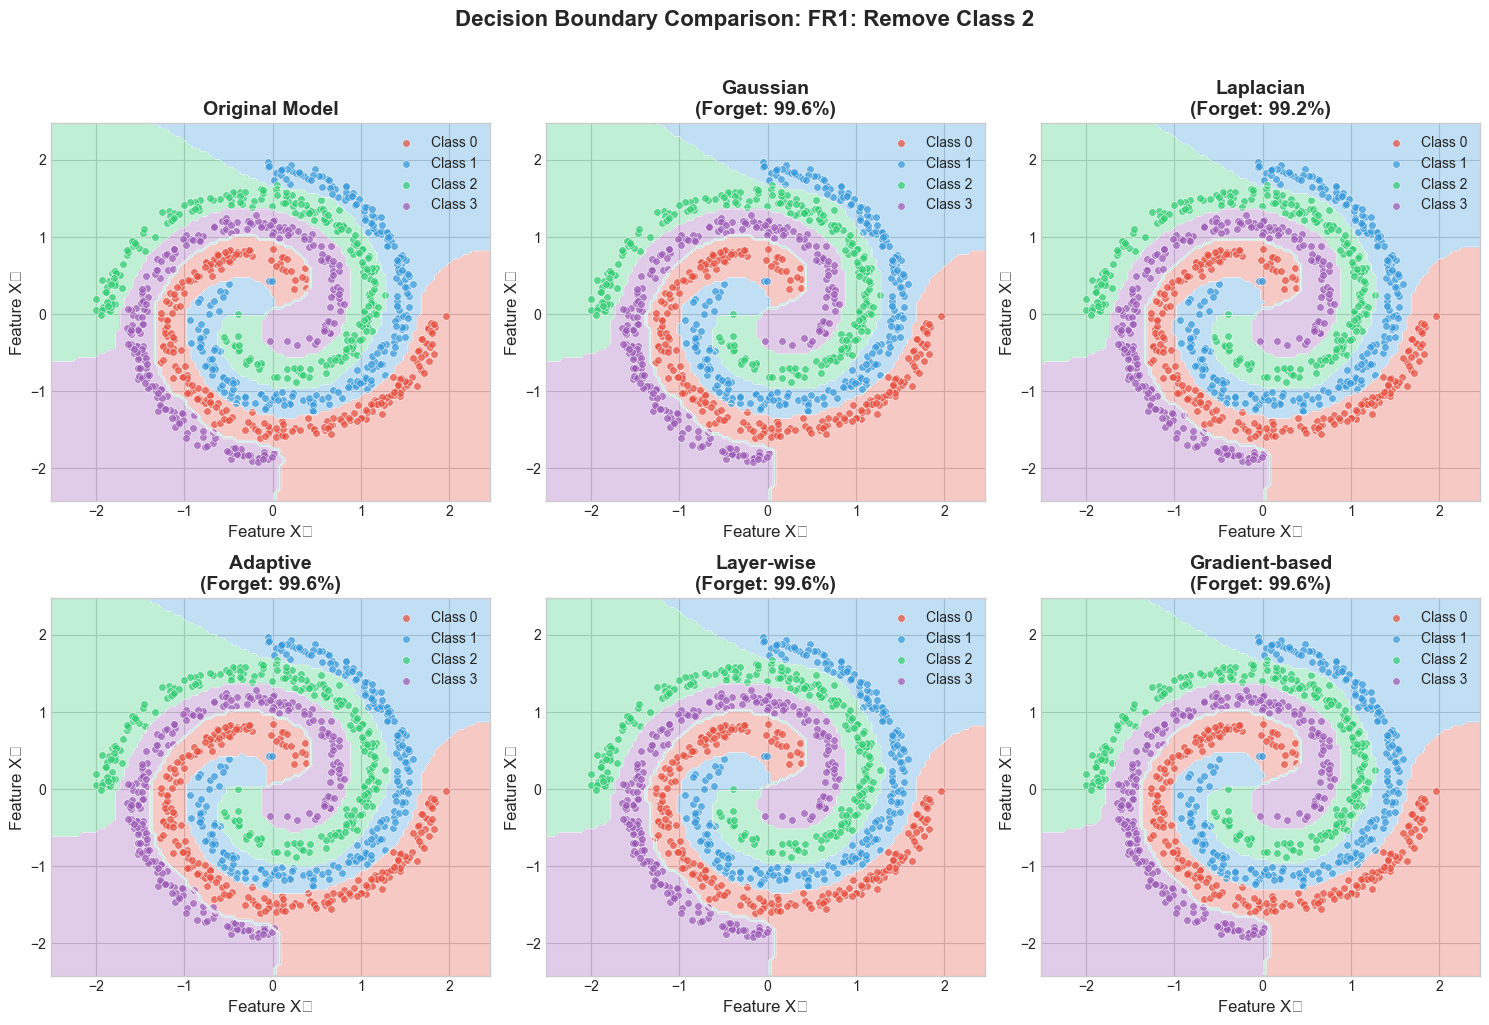


💡 Successful unlearning should show the Class 2 (green) region
   becoming fragmented or absorbed by other classes.


In [60]:
def plot_decision_boundary_comparison(
    original_model: TabNetClassifier,
    unlearned_models: dict,
    fr: ForgetRequest,
    fr_name: str
) -> None:
    """
    Compare decision boundaries before and after unlearning.
    
    Args:
        original_model: Original trained model
        unlearned_models: Dictionary of strategy_name -> unlearned model
        fr: ForgetRequest with data
        fr_name: Name of the forget request
    """
    n_models = len(unlearned_models) + 1  # +1 for original
    ncols = 3
    nrows = (n_models + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5*nrows))
    axes = axes.flatten() if n_models > 1 else [axes]
    
    # Combine retain and forget data for visualization
    X_all = np.vstack([fr.X_retain, fr.X_forget])
    y_all = np.concatenate([fr.y_retain, fr.y_forget])
    
    # Plot original model
    plot_decision_boundary(
        original_model, X_all, y_all,
        title="Original Model",
        resolution=100, ax=axes[0]
    )
    
    # Plot unlearned models
    for idx, (strategy_name, model) in enumerate(unlearned_models.items(), 1):
        if idx < len(axes):
            metrics = all_results[fr_name][strategy_name]
            plot_decision_boundary(
                model, X_all, y_all,
                title=f"{strategy_name}\n(Forget: {metrics.forget_accuracy:.1%})",
                resolution=100, ax=axes[idx]
            )
    
    # Hide unused subplots
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f"Decision Boundary Comparison: {fr_name}", 
                fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


# Plot for FR1 (main experiment)
fr1_name = 'FR1: Remove Class 2'
plot_decision_boundary_comparison(
    tabnet_model,
    all_models[fr1_name],
    forget_requests[fr1_name],
    fr1_name
)

print("\n💡 Successful unlearning should show the Class 2 (green) region")
print("   becoming fragmented or absorbed by other classes.")

### 9.4 MIA Resistance Analysis

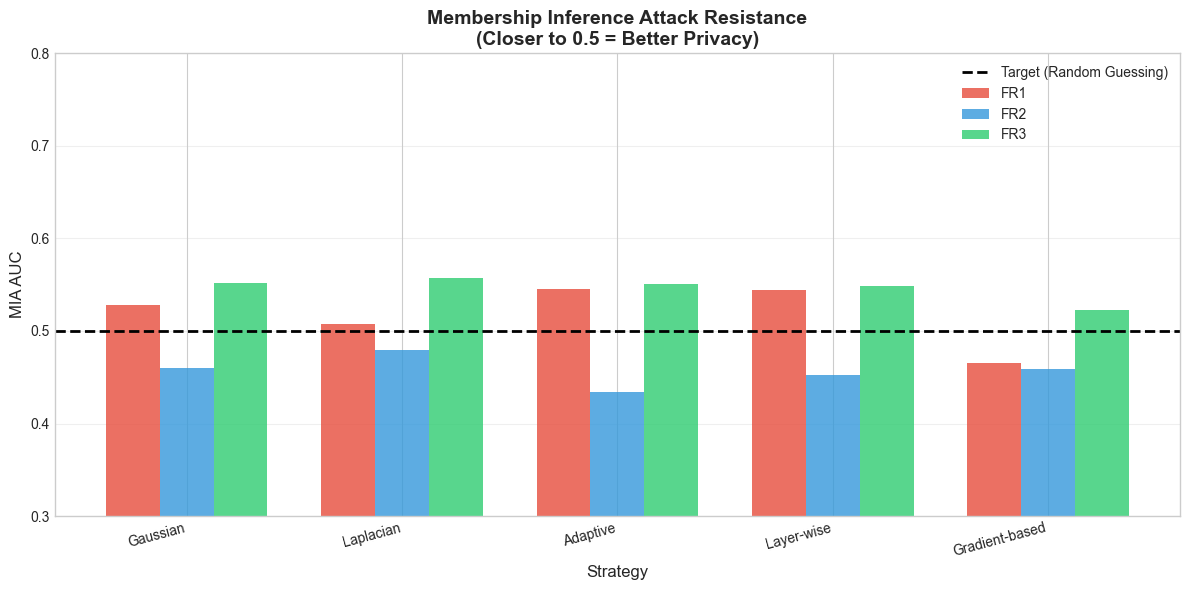


📊 MIA AUC Interpretation:
  • AUC = 0.5: Perfect privacy (attacker guesses randomly)
  • AUC > 0.5: Some information leakage (attacker does better than random)
  • AUC = 1.0: Complete leakage (attacker perfectly identifies members)


In [61]:
def plot_mia_analysis(results_df: pd.DataFrame) -> None:
    """
    Visualize Membership Inference Attack resistance.
    
    Args:
        results_df: DataFrame with results
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Group by strategy
    strategies = results_df['Strategy'].unique()
    x = np.arange(len(strategies))
    width = 0.25
    
    forget_requests = results_df['Forget Request'].unique()
    colors = ['#E74C3C', '#3498DB', '#2ECC71']
    
    for idx, fr_name in enumerate(forget_requests):
        fr_data = results_df[results_df['Forget Request'] == fr_name]
        mia_values = [fr_data[fr_data['Strategy'] == s]['MIA AUC'].values[0] 
                     for s in strategies]
        
        bars = ax.bar(x + idx*width, mia_values, width, 
                     label=fr_name.split(':')[0], color=colors[idx], alpha=0.8)
    
    # Add target line
    ax.axhline(y=0.5, color='black', linestyle='--', linewidth=2, 
              label='Target (Random Guessing)')
    
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MIA AUC')
    ax.set_title('Membership Inference Attack Resistance\n(Closer to 0.5 = Better Privacy)', 
                fontweight='bold')
    ax.set_xticks(x + width)
    ax.set_xticklabels(strategies, rotation=15, ha='right')
    ax.legend(loc='upper right')
    ax.set_ylim(0.3, 0.8)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


plot_mia_analysis(results_df)

print("\n📊 MIA AUC Interpretation:")
print("  • AUC = 0.5: Perfect privacy (attacker guesses randomly)")
print("  • AUC > 0.5: Some information leakage (attacker does better than random)")
print("  • AUC = 1.0: Complete leakage (attacker perfectly identifies members)")

### 9.5 Confusion Matrix Analysis for Forget Set

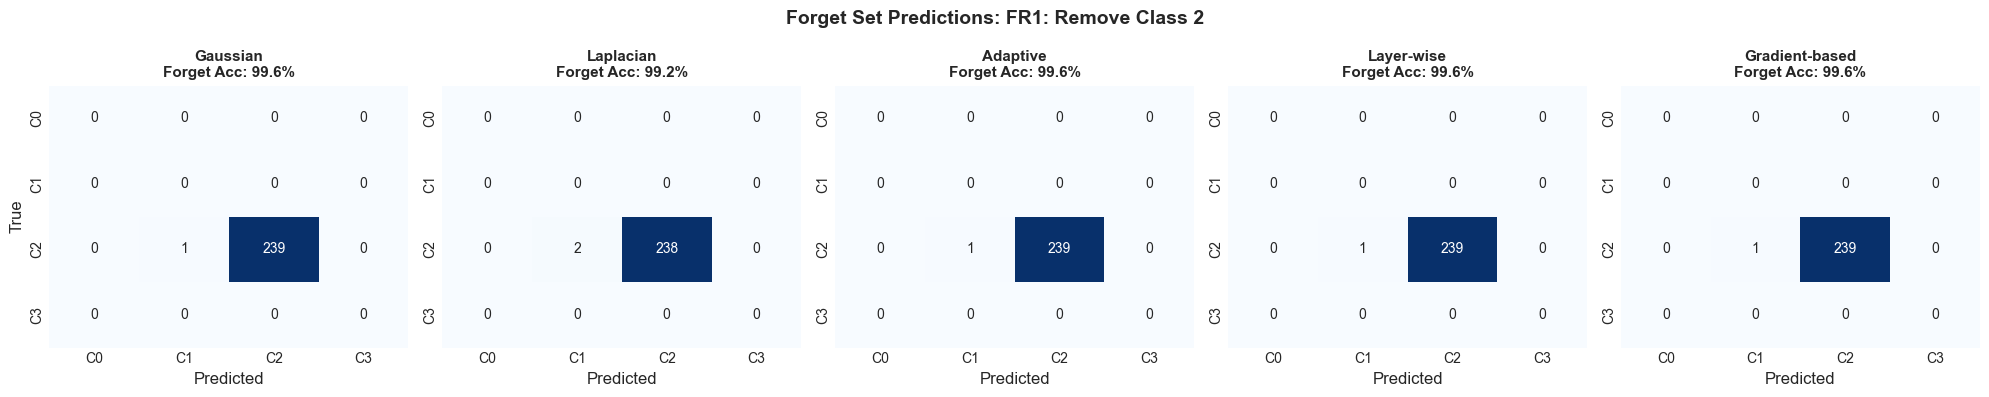


💡 Interpretation:
   • Good unlearning: Predictions spread across all columns (classes)
   • Poor unlearning: Predictions concentrated on the diagonal
   • Target: ~25% forget accuracy (random guessing)


In [62]:
def plot_forget_set_confusion(
    models: dict,
    fr: ForgetRequest,
    fr_name: str
) -> None:
    """
    Show confusion matrices for predictions on the forget set.
    
    For successful unlearning, predictions should be distributed
    across all classes (not concentrated in the true class).
    
    Args:
        models: Dictionary of strategy_name -> model
        fr: ForgetRequest with data
        fr_name: Name of the forget request
    """
    n_models = len(models)
    fig, axes = plt.subplots(1, min(n_models, 5), figsize=(4*min(n_models, 5), 4))
    if n_models == 1:
        axes = [axes]
    
    for idx, (strategy_name, model) in enumerate(list(models.items())[:5]):
        y_pred = model.predict(fr.X_forget)
        cm = confusion_matrix(fr.y_forget, y_pred, labels=list(range(config.num_classes)))
        
        # Calculate forget accuracy
        forget_acc = accuracy_score(fr.y_forget, y_pred)
        
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'C{i}' for i in range(config.num_classes)],
            yticklabels=[f'C{i}' for i in range(config.num_classes)],
            ax=axes[idx], cbar=False
        )
        
        # Highlight the "correct" predictions (which we want to minimize)
        axes[idx].set_title(f"{strategy_name}\nForget Acc: {forget_acc:.1%}", 
                          fontweight='bold', fontsize=11)
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True' if idx == 0 else '')
    
    plt.suptitle(f"Forget Set Predictions: {fr_name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interpretation:")
    print("   • Good unlearning: Predictions spread across all columns (classes)")
    print("   • Poor unlearning: Predictions concentrated on the diagonal")
    print(f"   • Target: ~{config.target_forget_accuracy:.0%} forget accuracy (random guessing)")


# Plot for FR1
plot_forget_set_confusion(
    all_models['FR1: Remove Class 2'],
    forget_requests['FR1: Remove Class 2'],
    'FR1: Remove Class 2'
)

### 9.6 Strategy Ranking

In [63]:
def rank_strategies(results_df: pd.DataFrame) -> pd.DataFrame:
    """
    Rank strategies across all forget requests.
    
    Uses balance_score as the primary ranking metric.
    
    Args:
        results_df: DataFrame with results
    
    Returns:
        DataFrame with rankings
    """
    # Calculate mean metrics per strategy (select numeric columns explicitly)
    numeric_cols = ['Retain Acc', 'Forget Acc', 'Test Acc', 'MIA AUC', 
                    'Param Distance', 'Balance Score', 'Time (s)']
    
    ranking = results_df.groupby('Strategy')[numeric_cols].mean().round(4)
    
    # Sort by balance score
    ranking = ranking.sort_values('Balance Score', ascending=False)
    
    # Add rank column
    ranking['Rank'] = range(1, len(ranking) + 1)
    
    return ranking


ranking_df = rank_strategies(results_df)

print("="*80)
print("STRATEGY RANKING (by Balance Score)")
print("="*80)
print("\nBalance Score = Retain Acc + Test Acc - Forget Acc")
print("(Higher is better)\n")
print(ranking_df.to_string())

print("\n" + "="*80)
print("RECOMMENDATION")
print("="*80)

best_strategy = ranking_df.index[0]
best_score = ranking_df.loc[best_strategy, 'Balance Score']
best_forget = ranking_df.loc[best_strategy, 'Forget Acc']

print(f"\n🏆 Best Strategy: {best_strategy}")
print(f"   Balance Score: {best_score:.4f}")
print(f"   Forget Accuracy: {best_forget:.4f} (target: {config.target_forget_accuracy:.2f})")

STRATEGY RANKING (by Balance Score)

Balance Score = Retain Acc + Test Acc - Forget Acc
(Higher is better)

                Retain Acc  Forget Acc  Test Acc  MIA AUC  Param Distance  Balance Score  Time (s)  Rank
Strategy                                                                                                
Layer-wise          0.9966      0.9986    0.9958   0.5150          0.7881         0.9938    0.0428     1
Gradient-based      0.9962      0.9969    0.9917   0.4824          0.2705         0.9910    0.0944     2
Gaussian            0.9966      0.9986    0.9917   0.5131          0.5381         0.9897    0.0826     3
Laplacian           0.9945      0.9972    0.9917   0.5147          0.7680         0.9890    0.0469     4
Adaptive            0.9924      0.9951    0.9833   0.5097          1.2179         0.9805    0.0452     5

RECOMMENDATION

🏆 Best Strategy: Layer-wise
   Balance Score: 0.9938
   Forget Accuracy: 0.9986 (target: 0.25)


---

<a id="10-conclusions"></a>
## 10. Conclusions & Future Work

### 10.1 Key Findings

In [64]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

# Analyze results
avg_metrics = results_df.groupby('Strategy')[['Retain Acc', 'Forget Acc', 'Test Acc', 'MIA AUC', 'Balance Score', 'Time (s)']].mean()

print("\n1. FORGETTING EFFECTIVENESS")
print("-"*40)
for strategy in avg_metrics.index:
    forget_acc = avg_metrics.loc[strategy, 'Forget Acc']
    status = "✓ Good" if forget_acc < 0.35 else "✗ Needs improvement"
    print(f"   {strategy:15s}: {forget_acc:.3f} ({status})")

print(f"\n   Target: {config.target_forget_accuracy:.2f} (random guessing)")

print("\n2. UTILITY PRESERVATION")
print("-"*40)
for strategy in avg_metrics.index:
    retain_acc = avg_metrics.loc[strategy, 'Retain Acc']
    test_acc = avg_metrics.loc[strategy, 'Test Acc']
    status = "✓ Good" if retain_acc > 0.7 else "✗ Significant degradation"
    print(f"   {strategy:15s}: Retain={retain_acc:.3f}, Test={test_acc:.3f} ({status})")

print("\n3. PRIVACY GUARANTEE (MIA Resistance)")
print("-"*40)
for strategy in avg_metrics.index:
    mia_auc = avg_metrics.loc[strategy, 'MIA AUC']
    distance_from_target = abs(mia_auc - 0.5)
    status = "✓ Good" if distance_from_target < 0.1 else "⚠ Some leakage"
    print(f"   {strategy:15s}: AUC={mia_auc:.3f} ({status})")

print("\n4. COMPUTATIONAL EFFICIENCY")
print("-"*40)
for strategy in avg_metrics.index:
    time_s = avg_metrics.loc[strategy, 'Time (s)']
    speedup = baseline_metrics['training_time'] / time_s if time_s > 0 else float('inf')
    print(f"   {strategy:15s}: {time_s:.4f}s ({speedup:.0f}× faster than retraining)")

KEY FINDINGS

1. FORGETTING EFFECTIVENESS
----------------------------------------
   Adaptive       : 0.995 (✗ Needs improvement)
   Gaussian       : 0.999 (✗ Needs improvement)
   Gradient-based : 0.997 (✗ Needs improvement)
   Laplacian      : 0.997 (✗ Needs improvement)
   Layer-wise     : 0.999 (✗ Needs improvement)

   Target: 0.25 (random guessing)

2. UTILITY PRESERVATION
----------------------------------------
   Adaptive       : Retain=0.992, Test=0.983 (✓ Good)
   Gaussian       : Retain=0.997, Test=0.992 (✓ Good)
   Gradient-based : Retain=0.996, Test=0.992 (✓ Good)
   Laplacian      : Retain=0.995, Test=0.992 (✓ Good)
   Layer-wise     : Retain=0.997, Test=0.996 (✓ Good)

3. PRIVACY GUARANTEE (MIA Resistance)
----------------------------------------
   Adaptive       : AUC=0.510 (✓ Good)
   Gaussian       : AUC=0.513 (✓ Good)
   Gradient-based : AUC=0.482 (✓ Good)
   Laplacian      : AUC=0.515 (✓ Good)
   Layer-wise     : AUC=0.515 (✓ Good)

4. COMPUTATIONAL EFFICIENCY
--

### 10.2 Limitations and Future Work

In [65]:
print("="*80)
print("LIMITATIONS")
print("="*80)
print("""
1. DATASET LIMITATIONS
   • Synthetic spiral dataset may not represent real-world complexity
   • Limited to 4 classes and 1,200 samples
   • 2D features limit generalization to high-dimensional data

2. EVALUATION LIMITATIONS
   • MIA uses simple confidence-based attack (more sophisticated attacks exist)
   • No certified unlearning guarantees computed
   • Single random seed (should run multiple seeds for robustness)

3. METHOD LIMITATIONS
   • Default hyperparameters may not be optimal for all scenarios
   • No repair step implemented after gradient ascent
   • No comparison with SISA or other exact unlearning methods
""")

print("="*80)
print("FUTURE WORK")
print("="*80)
print("""
1. EXTEND TO REAL DATASETS
   • Adult Income, MNIST, CIFAR-10
   • Larger scale experiments

2. IMPLEMENT CERTIFIED UNLEARNING
   • Compute (ε,δ) guarantees following Guo et al. (2020)
   • Compare with differential privacy bounds

3. ADD REPAIR STEP
   • Fine-tune on retain set after gradient ascent
   • Implement full "impair-repair" paradigm

4. ADVANCED ATTACKS
   • Likelihood ratio MIA
   • Shadow model attacks
   • Extraction attacks

5. SELECTIVE NOISE INJECTION
   • Implement SalUn-style gradient saliency
   • Target only parameters with high forget-set influence
""")

LIMITATIONS

1. DATASET LIMITATIONS
   • Synthetic spiral dataset may not represent real-world complexity
   • Limited to 4 classes and 1,200 samples
   • 2D features limit generalization to high-dimensional data

2. EVALUATION LIMITATIONS
   • MIA uses simple confidence-based attack (more sophisticated attacks exist)
   • No certified unlearning guarantees computed
   • Single random seed (should run multiple seeds for robustness)

3. METHOD LIMITATIONS
   • Default hyperparameters may not be optimal for all scenarios
   • No repair step implemented after gradient ascent
   • No comparison with SISA or other exact unlearning methods

FUTURE WORK

1. EXTEND TO REAL DATASETS
   • Adult Income, MNIST, CIFAR-10
   • Larger scale experiments

2. IMPLEMENT CERTIFIED UNLEARNING
   • Compute (ε,δ) guarantees following Guo et al. (2020)
   • Compare with differential privacy bounds

3. ADD REPAIR STEP
   • Fine-tune on retain set after gradient ascent
   • Implement full "impair-repair" paradi

---

<a id="11-references"></a>
## 11. References

### Foundational Papers

1. **Cao, Y., & Yang, J. (2015).** "Towards Making Systems Forget with Machine Unlearning." *IEEE Symposium on Security and Privacy.* [First formal definition of machine unlearning]

2. **Bourtoule, L., et al. (2021).** "Machine Unlearning." *IEEE Symposium on Security and Privacy.* [Introduced SISA training for efficient exact unlearning]

3. **Guo, C., et al. (2020).** "Certified Data Removal from Machine Learning Models." *ICML.* [Established (ε,δ)-certified removal via Newton updates and noise]

### Noise-Based Approaches

4. **Sekhari, A., et al. (2021).** "Remember What You Want to Forget: Algorithms for Machine Unlearning." *NeurIPS.* [Theoretical bounds separating unlearning from differential privacy]

5. **Neel, S., Roth, A., & Sharifi-Malvajerdi, S. (2021).** "Descent-to-Delete: Gradient-Based Methods for Machine Unlearning." *ALT.* [Gradient descent with Gaussian perturbation for unlearning]

6. **Fan, C., et al. (2024).** "SalUn: Empowering Machine Unlearning via Gradient-based Weight Saliency." *ICLR (Spotlight).* [State-of-the-art selective weight perturbation]

### Evaluation & Attacks

7. **Shokri, R., et al. (2017).** "Membership Inference Attacks Against Machine Learning Models." *IEEE S&P.* [Original membership inference attack methodology]

8. **Chen, M., et al. (2021).** "When Machine Unlearning Jeopardizes Privacy." *ACM CCS.* [Analysis of privacy risks in unlearning]

### Architecture

9. **Arık, S. Ö., & Pfister, T. (2021).** "TabNet: Attentive Interpretable Tabular Learning." *AAAI.* [TabNet architecture for tabular data]

### Recent Advances

10. **NeurIPS 2023 Machine Unlearning Competition.** "Are We Making Progress in Unlearning?" *NeurIPS Competition Track.* [Large-scale evaluation of unlearning methods]

---

## Notebook Information

In [66]:
import platform
from datetime import datetime

print("="*60)
print("NOTEBOOK EXECUTION INFORMATION")
print("="*60)
print(f"\nExecution timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python version: {platform.python_version()}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"\nRandom seed used: {config.seed}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

print("\n" + "="*60)
print("END OF NOTEBOOK")
print("="*60)

NOTEBOOK EXECUTION INFORMATION

Execution timestamp: 2025-12-27 23:50:56
Python version: 3.12.10
PyTorch version: 2.7.1+cpu
NumPy version: 2.3.1
Pandas version: 2.3.0

Random seed used: 42
Device: CPU

END OF NOTEBOOK
